# **Trabajo Final Integrador - Grupo U**

# **Predicci√≥n del Abandono de Clientes en Banca mediante modelos de Machine Learning - Regresi√≥n Log√≠stica | K-NN | Random Forest | Light GBM | XGBoost**


In [ ]:
# --- CONFIGURACI√ìN INICIAL PARA GOOGLE COLAB ---
!git clone https://github.com/L07IA/DCDDyAA-Trabajo-Final-Integrador-GrupoU.git
%cd DCDDyAA-Trabajo-Final-Integrador-GrupoU

# Instala las dependencias
!pip install -r requirements.txt

# **0. Librer√≠as a utilizar**

In [ ]:
# 1. Instalaci√≥n de las librer√≠as necesarias
!pip install lightgbm
!pip install imbalanced-learn
!pip install xgboost

# 2. Para manipulaci√≥n de datos y visualizaci√≥n
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import chi2_contingency

# 3. Para preprocesamiento - manejo del desbalance - modelado
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder,LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer


# 4. Modelos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb


# 5. Para evaluaci√≥n
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report


# Configuraciones adicionales para una mejor visualizaci√≥n
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
import warnings
warnings.filterwarnings('ignore')

print("Todas las librer√≠as necesarias se han importado correctamente")

Todas las librer√≠as necesarias se han importado correctamente


# **1. Carga de Datos**


In [ ]:
try:
    df = pd.read_csv('Customer-Churn-Records.csv')

    print("Forma del dataset:", df.shape)

    print("\nPrimeras 5 filas del df:")
    display(df.head())

except FileNotFoundError:
    print("El archivo 'Customer-Churn-Records.csv' no se encuentra.")
    print("Aseg√∫rate de que el archivo .csv de la competencia est√© subido al directorio de Google Colab.")


Forma del dataset: (10000, 18)

Primeras 5 filas del df:


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   Point Earned  
0           464  
1           456  
2           377  
3           350  
4           425

# **2. An√°lisis Exploratorio de Datos (EDA)**

## En esta fase se explora el dataset para entender mejor los datos, encontrar patrones, identificar valores faltantes y outliers y visualizar relaciones entre las caracter√≠sticas y la variable objetivo (`Exited`).

# 2.1 An√°lisis Global

In [ ]:
# Analizar informaci√≥n general y tipos de datos
df.info()

# Revisar la distribuci√≥n de la variable objetivo (Exited)
# Desbalance de clases
print("\nDistribuci√≥n de la variable 'Exited':")
print(df['Exited'].value_counts())
print("\nPorcentaje de clientes que abandonaron (1) vs. los que no (0):")
print(df['Exited'].value_counts(normalize=True) * 100)

# Ver las estad√≠sticas descriptivas de las variables num√©ricas
print("\nEstad√≠sticas descriptivas de las variables num√©ricas:")
display(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

count          mean           std          min  \
RowNumber           10000.0  5.000500e+03   2886.895680         1.00   
CustomerId          10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore         10000.0  6.505288e+02     96.653299       350.00   
Age                 10000.0  3.892180e+01     10.487806        18.00   
Tenure              10000.0  5.012800e+00      2.892174         0.00   
Balance             10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts       10000.0  1.530200e+00      0.581654         1.00   
HasCrCard           10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember      10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary     10000.0  1.000902e+05  57510.492818        11.58   
Exited              10000.0  2.038000e-01      0.402842         0.00   
Complain            10000.0  2.044000e-01      0.403283         0.00   
Satisfaction Score  10000.0  3.013800e+00      1.405919         1.00   
Point Earned        10000.0  6.065151e+02    225.924839       119.00   

                            25%           50%           75%          max  
RowNumber               2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId          15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore              584.00  6.520000e+02  7.180000e+02       850.00  
Age                       32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                     3.00  5.000000e+00  7.000000e+00        10.00  
Balance                    0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts              1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard                  0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember             0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary        51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                     0.00  0.000000e+00  0.000000e+00         1.00  
Complain                   0.00  0.000000e+00  0.000000e+00         1.00  
Satisfaction Score         2.00  3.000000e+00  4.000000e+00         5.00  
Point Earned             410.00  6.050000e+02  8.010000e+02      1000.00

**An√°lisis de las variables - Hip√≥tesis**

- **RowNumber:** Corresponde al n√∫mero de filas - No se considera tenga efecto en la salida
- **CustomerId:** Contiene valores aleatorios - No se considera tenga efecto en la salida
- **Surname:** El apellido de un cliente - No se considera tenga efecto en la salida
- **CreditScore:** Puede tener un efecto en la salida - A mayor score crediticio se presume menor abandono.
- **Geography:** La ubicaci√≥n de un cliente podr√≠a afectar su decisi√≥n de dejar el banco.
- **Gender:** Ser√≠a interesante explorar si el g√©nero tiene efecto sobre el abandono
- **Edad:** La edad puede ser relevante en el abandono o no - Normalmente, los clientes mayores son m√°s leales y es menos probable que abandonen un banco.
- **Tenure:** Cantidad de a√±os que el cliente ha operado mediante el banco - Ser√≠a bueno ver el efecto sobre el abandono de esta variable.
- **Balance:** Posible indicador de la p√©rdida de cliente, ya que se presume que las personas con un saldo m√°s alto en sus cuentas tienen menos probabilidades de abandonar el banco en comparaci√≥n con aquellas con saldos m√°s bajos.
- **NumOfProducts:** Cantidad de producto que ha comprado con el banco - Se piensa que cuanto mas productos compra el cliente con el banco, menos probabilidad de abandono tendr√°.
- **HasCrCard:** Posesi√≥n o no de tarjeta de cr√©dito - Se piensa que una persona con tarjeta de cr√©dito tiene menos probabilidad de abandono
- **IsActiveMember:** Es menos probable que los clientes activos abandonen el banco.
- **Estimated Salary:** Ocurre lo mismo que con el saldo, las personas con salarios m√°s bajos tienen m√°s probabilidades de abandonar el banco en comparaci√≥n con aquellas con salarios m√°s altos.
- **Exited:** 1(abandono) - (0) No Abandono - variable objetivo (target)
- **Complain:** Si el cliente se a quejado o no - Ver el efecto de la queja sobre el abandono es sin duda relevante para este negocio.
- **Satisfaction Score:** Puntuaci√≥n de satisfacci√≥n - La satisfacci√≥n del cliente es sin duda una variable a considerar.
- **Card Type:** Tipo de tarjeta que tiene el cliente - Podr√≠a guardar una relaci√≥n con el abandono.
- **Point Earned:** Puntos ganados por el cliente al usar trajetas de credito - Podr√≠a guardar una realaci√≥n con el abandono.

**Observaciones**

- **18** variables en total
- **Dataset desbalanceado:** Solo el 20,38 % de los clientes han abandonado
- **Variables irrelevantes:** **Row Number - CostumberID - Surname** (se consideran que no tienen valor predictivo)
- La variable **Balance** presenta muchos ceros, lo que podr√≠a afectar al rendimiento del modelo, por lo que ser√≠a necesaria analizarla mas a fondo


**Columnas categ√≥ricas y Num√©ricas**

In [ ]:
# Ver columnas categ√≥ricas y num√©ricas
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns.tolist()

print("Variables Categoricas: ",cat_cols)
print("Variables Numericas: ",num_cols)

Variables Categoricas:  ['Surname', 'Geography', 'Gender', 'Card Type']
Variables Numericas:  ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']


Se tiene un total de **18** variables (con la target - **Exited** - incluida)

**Se observan 4 variables categ√≥ricas "tipo objeto"**:
- Surname: Car√°cter nominal - No relevante
- Geography: Car√°cter Nominal
- Gender: Car√°cter Dicot√≥mico
- Card Type: Car√°cter Nominal - Podr√≠a considerarse ordinal desde el punto de vista de un rango de beneficios de la tarjeta, pero esto no es relevante para nuestro an√°lisis.

**Se observan 14 variables num√©ricas**:
1) Exited (**target**) - 1(clase positiva) | 0 (Clase negativa)
2) Row Number y Costumer ID (**no relevantes**) (2)
3) **6 continuas**
- Credit Score
- Age
- Tenure
- Balance
- Estimated Salary
- Point Earned
4) **5 categ√≥ricas codificadas**
- Num of Product: Car√°cter ordinal
- Has Card: Car√°cter Dicot√≥mico
- Is Active Member: Car√°cter Dicot√≥mico
- Complain: Car√°cter Dicot√≥mico
- Satisfacci√≥n Score: Car√°cter Ordinal

**Nota**:
- Las conclusiones sobre las variables num√©ricas y categ√≥ricas ser√°n demostadas al explorar las gr√°ficas del **EDA**.
- **Variable categ√≥rica tipo objeto**: Se consideran asi a aquellas variables categ√≥ricas que el comando df.info() ha clasificado como objeto.
- **Variables categ√≥ricas codificadas**: Se consideran asi a aquellas variables categ√≥ricas que presentan en su salida un car√°cter dicot√≥mico num√©rico (1/0) o un rango considerado discreto y no muy extenso, de manera de ser consideradas variables categ√≥ricas ordinales o nominales, seg√∫n corresponda.
- **Variables num√©ricas continuas**: Se consideran asi a las variables num√©ricas que pueden tomar te√≥ricamente un conjunto infinito de valores posibles dentro de un rango.

# 2.2  Identificaci√≥n de valores faltantes y duplicados


Valores faltantes por columna:
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


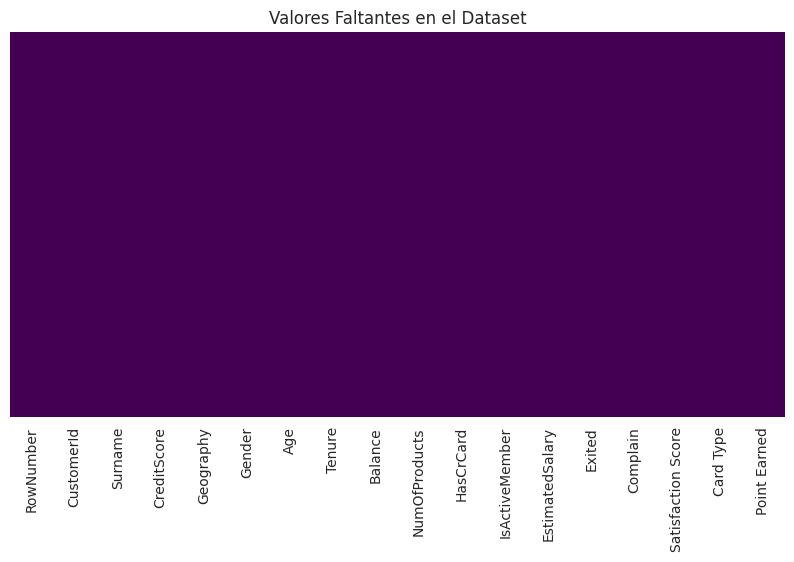


Duplicados:


RowNumber             10000
CustomerId            10000
Surname                2932
CreditScore             460
Geography                 3
Gender                    2
Age                      70
Tenure                   11
Balance                6382
NumOfProducts             4
HasCrCard                 2
IsActiveMember            2
EstimatedSalary        9999
Exited                    2
Complain                  2
Satisfaction Score        5
Card Type                 4
Point Earned            785
dtype: int64

In [ ]:
# Identificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Visualizaci√≥n de valores faltantes
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Valores Faltantes en el Dataset")
plt.show()

# Duplicados
print("\nDuplicados:")
df.nunique()

**Observaciones**

- **RowNumber y CustomerId** : Presentan 10.000 valores √∫nicos, uno por cada fila, infieriendo que cada registro del dataset es √∫nico. Esto es ideal para el an√°lisis y el modelado.

- **Identificaci√≥n de variables categ√≥ricas**: El valor de (2) en **Gender - Has Card - Complain - Is Active Member** indican que son **categ√≥ricas dicot√≥micas** |  La presencia valores √∫nicos en columnas como **Geography (3) - Card Type (4)** indican que son **variables categ√≥ricas nominales** | La presencia de valores √∫nicos en **NumOfProducts (4)- Satisfaction Score (5)** indican que son **variables categ√≥ricas ordinales**| **Surname** completa las 9 variables categ√≥ricas.


## 2.3. An√°lisis univariado: Distribuci√≥n de las variables num√©ricas

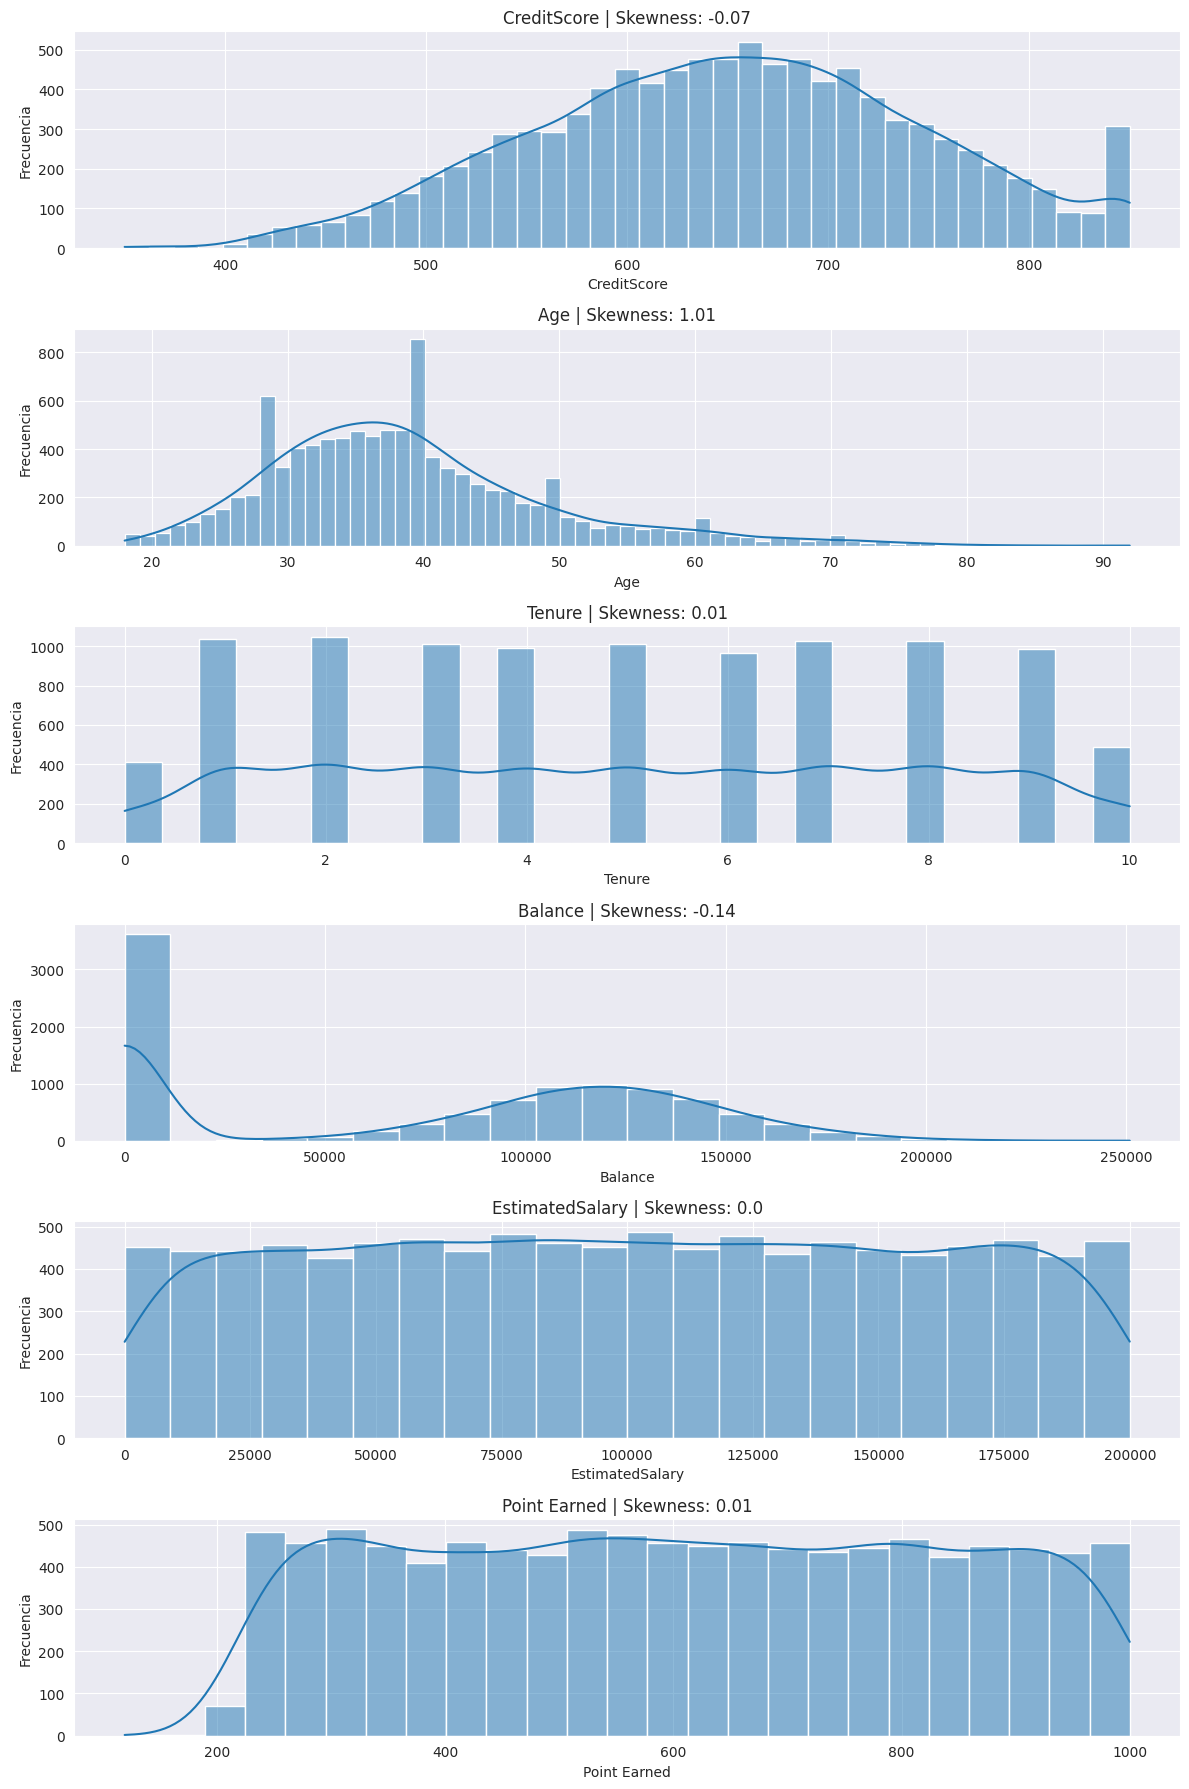

In [ ]:
# Variables num√©ricas de inter√©s
numerical_columns_to_plot = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']

# Estilo de gr√°fico
sns.set_style("darkgrid")

# Tama√±o de la figura
plt.figure(figsize=(12, len(numerical_columns_to_plot) * 3))

# Creacion de los histogramas
for idx, feature in enumerate(numerical_columns_to_plot, 1):
    plt.subplot(len(numerical_columns_to_plot), 1, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")
    plt.xlabel(feature)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


**Resumen de Variables Num√©ricas Continuas**


- **Credit Score** presenta una tendencia normal, ligeramente sesgada a la izquierda
- **Age** presenta un sesgo a la derecha
- **Tenure - EstimatedSalary -  Point Earned**: Distribuci√≥nes uniformes
- **Balance** presenta una cierta normalidad
- **Credit Score - Age - Balance** presentan datos at√≠picos en frecuencia


**Deducciones visuales**

- Sesgo de los Datos (**Credit Score - Age**): El sesgo en estas variables indica que la mayor√≠a de los clientes tienen puntuaciones de cr√©dito m√°s altas **(550-750)** y edades entre **30 y 45 a√±os**, lo cual puede ser un factor importante para el abandono. **(Los valores brindados son estimaciones)**

- El an√°lisis de **Balance** es clave. La gran cantidad de **ceros** en Balance podr√≠a ser una variable predictiva muy fuerte.

- Distribuci√≥n Uniforme (**Tenure - EstimatedSalary - Point Earned**): Esta uniformidad sugiere que estas variables no tienen un valor "t√≠pico". Todos los valores en el rango son igualmente probables, lo que podr√≠an no tener implicaciones en c√≥mo se relacionan con el abandono.


## 2.4. An√°lisis Bivariado:

- **Relaci√≥n entre variables num√©ricas y categ√≥ricas con la variable objetivo (`Exited`)**

- **Relaci√≥n entre variables num√©ricas**

### 2.4.1. Variable positiva (Exited) seg√∫n variables categ√≥ricas tipo objeto

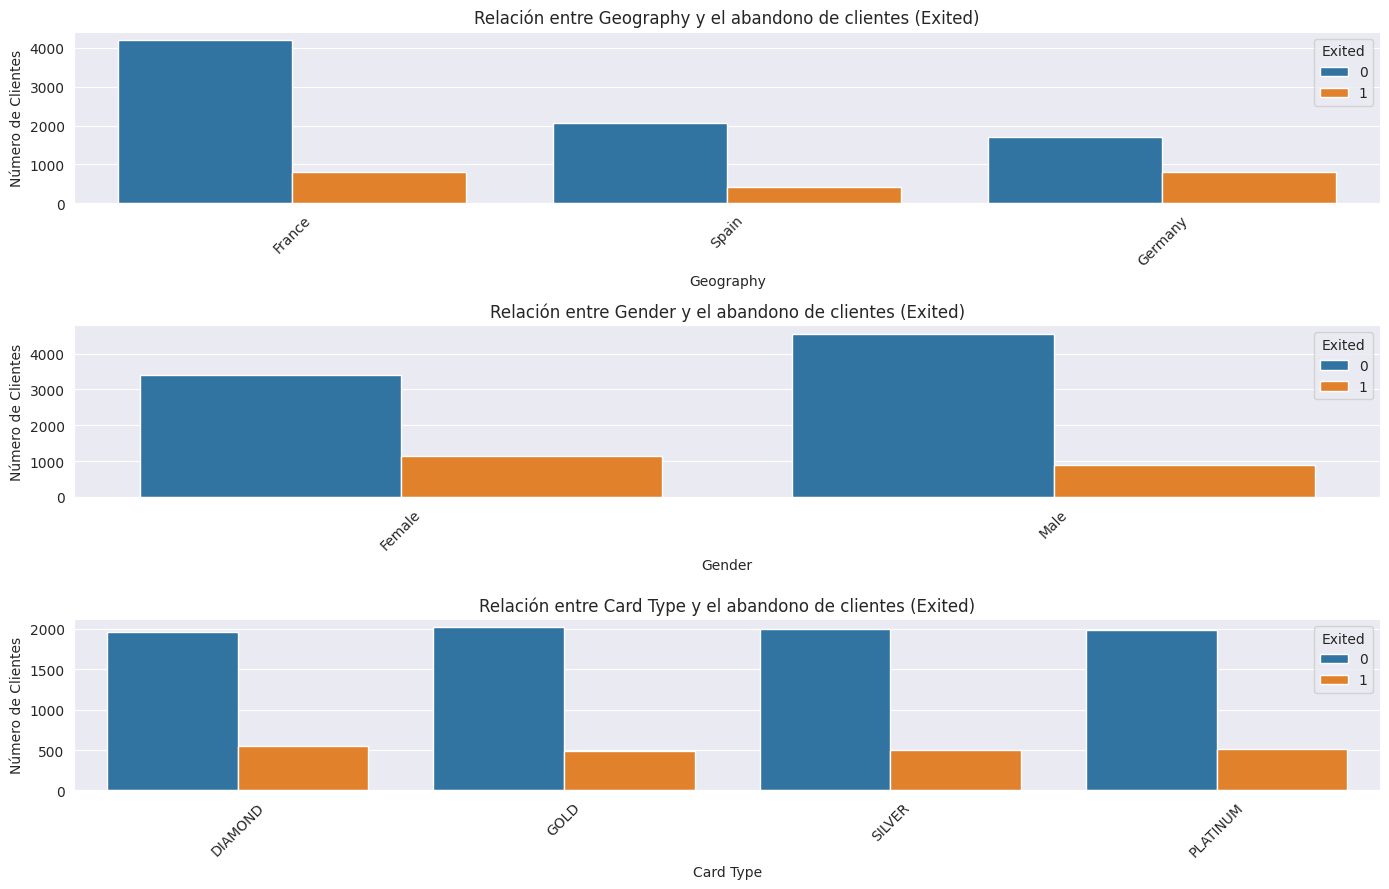

In [ ]:
# Variable objetivo
target = 'Exited'

# Seleccionar las columnas categ√≥ricas y eliminar 'Surname'
# df.select_dtypes(include="object").columns selecciona todas las columnas de tipo 'object'
# .drop('Surname') elimina la columna 'Surname' de esa selecci√≥n
categorical_columns = df.select_dtypes(include="object").columns.drop('Surname')

# Tama√±o de la figura para que todos los gr√°ficos se vean bien
plt.figure(figsize=(14, len(categorical_columns) * 3))

# Gr√°fico de barras
for idx, feature in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, idx)
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f"Relaci√≥n entre {feature} y el abandono de clientes ({target})")
    plt.xticks(rotation=45)
    plt.ylabel("N√∫mero de Clientes")

plt.tight_layout()
plt.show()

**Observaciones**


- Se elimino el **Apellido** por la baja predictividad
- En **proporci√≥n**, Francia fue el pa√≠s mas fiel y Espa√±a fue mas fiel que Alemania
- El **genero** femenino abandona m√°s que el masculino
- El **Tipo de tarjeta** parece no inferir respecto al abandono
- No se consideraron Variables Categ√≥ricas codificadas:
**NumOfProducts - HasCrCard - IsActiveMember - Complain - Satisfaction Score**

**Geography - Gender parecen ser variables predictoras**


### 2.4.2. Variable positiva (Exited) seg√∫n variables categ√≥ricas codificadas

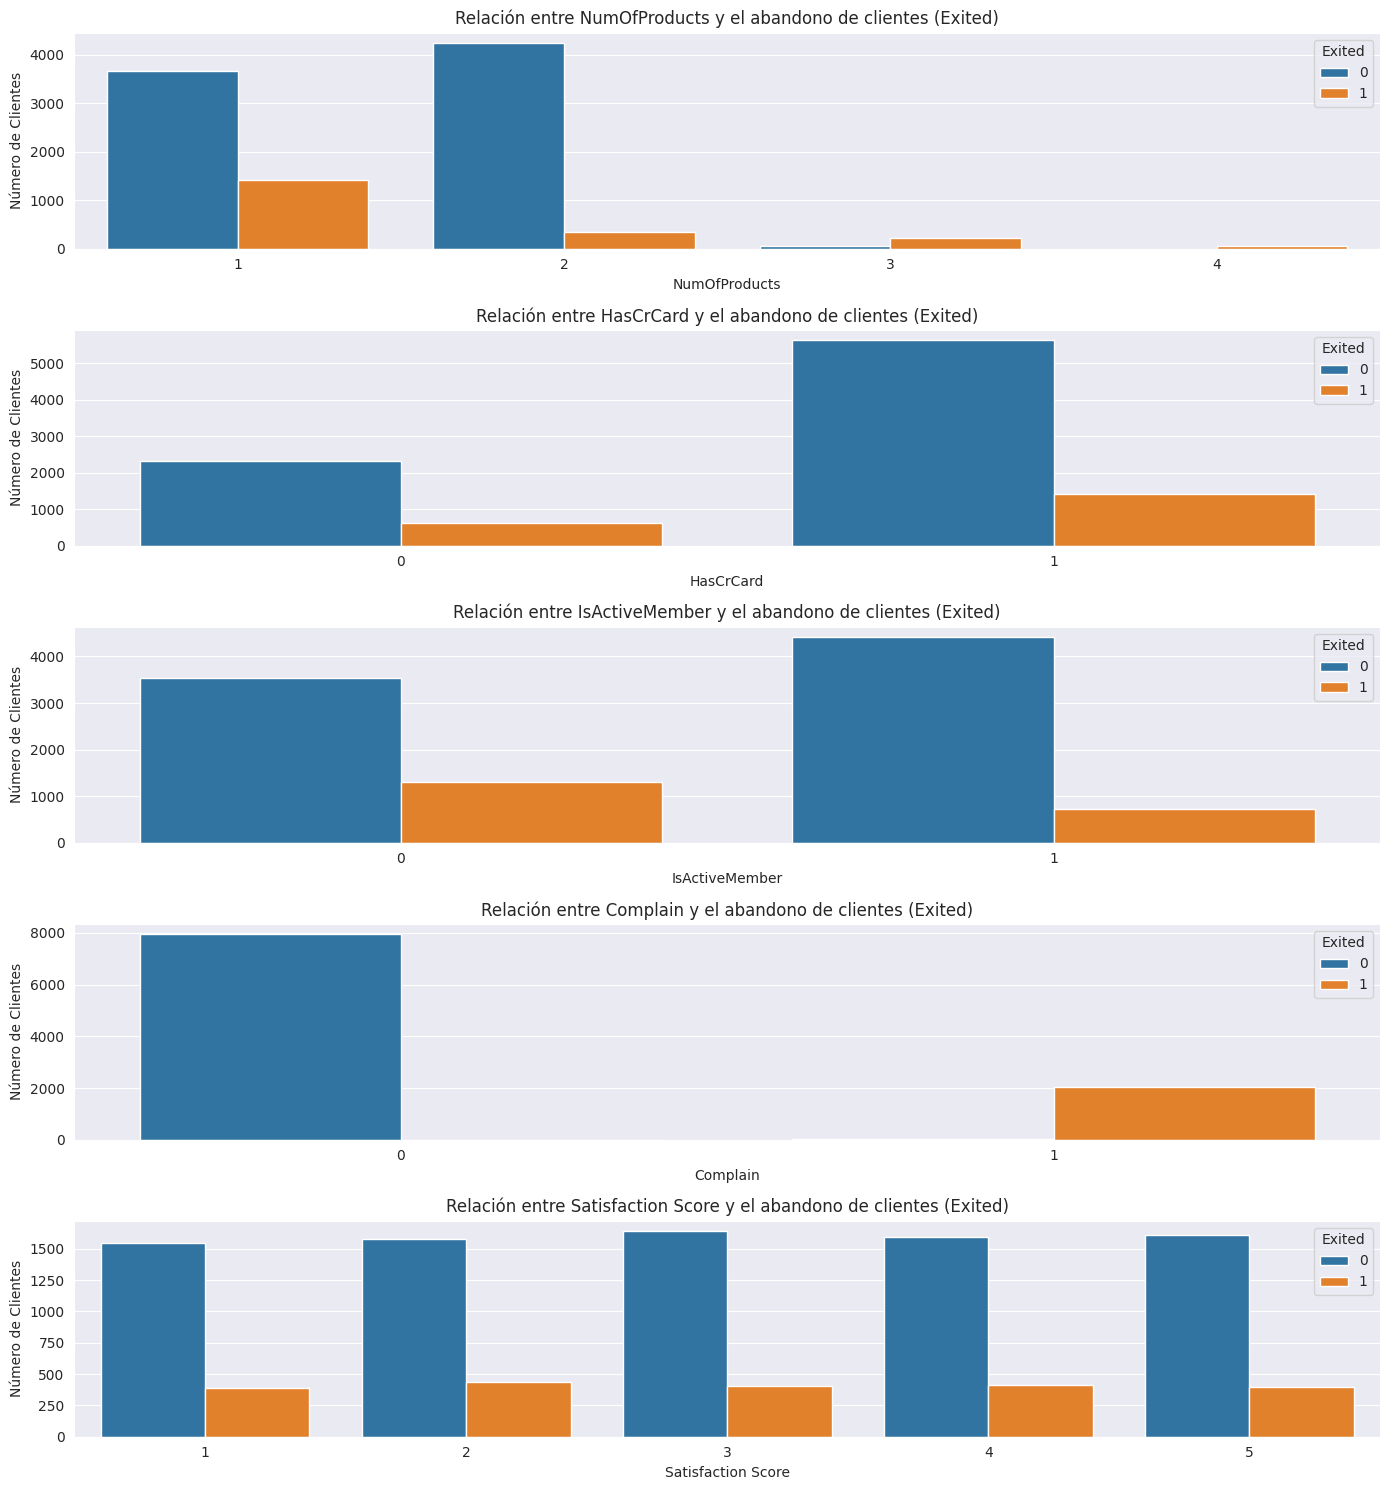

In [ ]:
# Variable Objetivo
target = 'Exited'

# Variables categ√≥ricas codificadas
encoded_categorical_columns = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score']

# Tama√±o del gr√°fico
plt.figure(figsize=(14, len(encoded_categorical_columns) * 3))

# Iterar sobre las columnas para crear un gr√°fico de barras para cada una
for idx, feature in enumerate(encoded_categorical_columns, 1):
    plt.subplot(len(encoded_categorical_columns), 1, idx)
    sns.countplot(data=df, x=feature, hue=target)
    plt.title(f"Relaci√≥n entre {feature} y el abandono de clientes ({target})")
    plt.xticks(rotation=0)  # No es necesario rotar, los nombres son cortos
    plt.ylabel("N√∫mero de Clientes")

plt.tight_layout()
plt.show()


**Observaciones**


- A medida que aumenta el **n√∫mero de productos** adquiridos mediante el banco, el abandono tiende a disminuir, aunque a partir de tres productos se observa un leve repunte en la tasa de salida.
- De los que tenian tarjetas, la mayor cantidad **no ha abandonado**.
- De los que eran miembros activos, la mayor cantidad **no ha abandonado**.
- La **queja** tiene un gran papel en la permanencia o ausencia ( existe un desbalance)
- De acuerdo al **score de satisfacci√≥n**, no se evidencian diferencias significativas hacia el abandono.
- Se puede ver como la clasificaci√≥n de estas **variables en categ√≥ricas codificadas** toma importancia en el c√≥digo del **EDA**

**Se considera que Num of Product - Has Card - Is Active Member - Complain son variables predictoras**

# **Hasta el momento se puede decir que de las 8 variables categ√≥ricas que exploramos, 6 se consideran predictoras**

### 2.4.3. Variables num√©ricas seg√∫n la clase positiva (Exited) y la clase negativa.

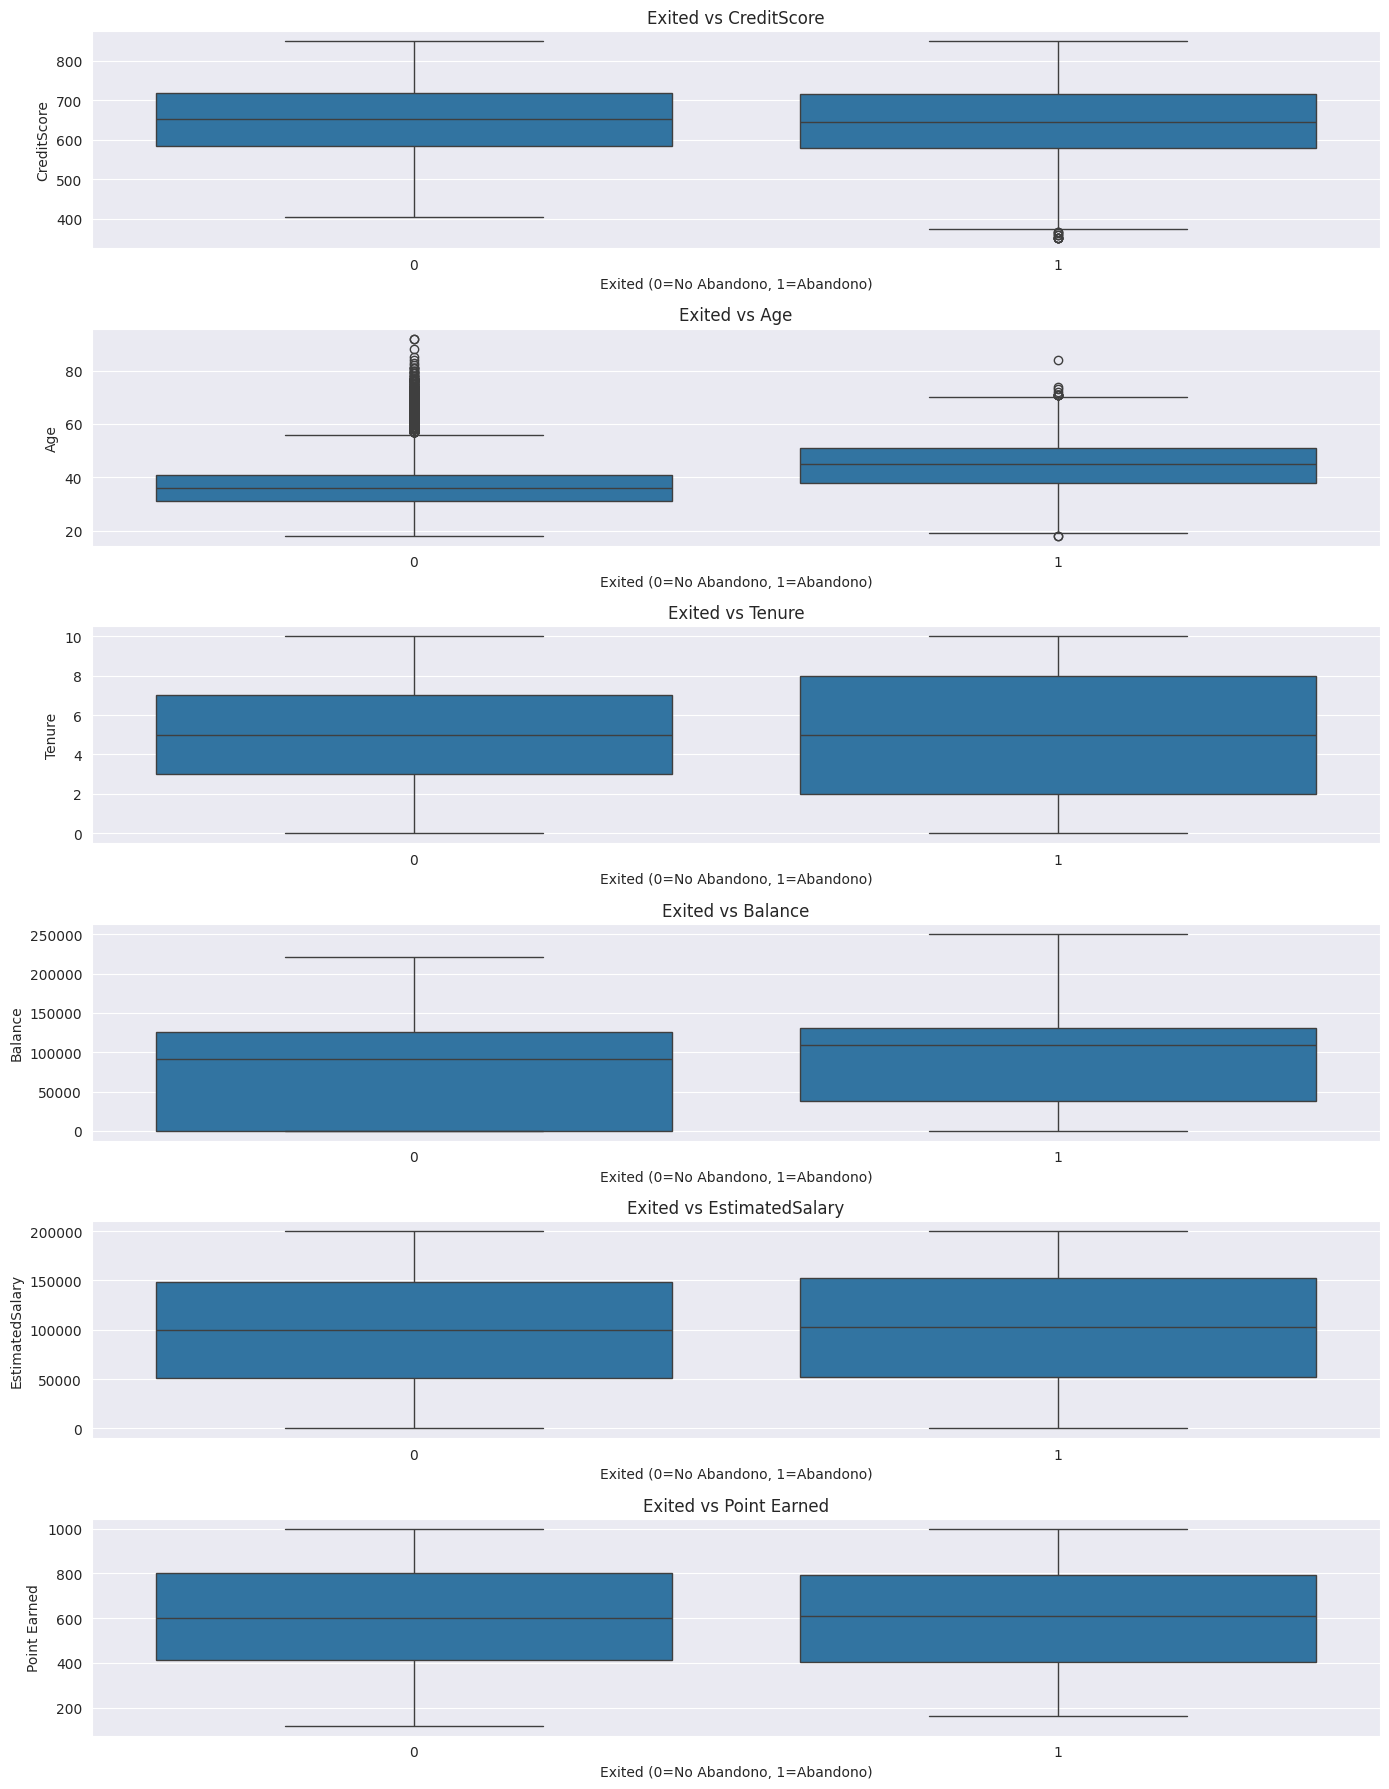

In [ ]:
# Definir la variable objetivo
target = 'Exited'

# Seleccionar solo las columnas num√©ricas que te interesan
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']

# Configurar el tama√±o del gr√°fico para una mejor visualizaci√≥n
# El n√∫mero de filas se ajusta din√°micamente seg√∫n la cantidad de columnas
plt.figure(figsize=(14, len(numerical_columns) * 3))

# Iterar sobre las columnas num√©ricas para crear un boxplot para cada una
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.boxplot(data=df, x=target, y=feature)
    plt.title(f"{target} vs {feature}")
    plt.xlabel("Exited (0=No Abandono, 1=Abandono)")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

**Resultados de cada variable sobre la target**

- **Cedit Score**: Distribuci√≥n similar para abandono o no - Parece no ser predictora.
- **Age**: La mediana de la edad de los que abandonan es considerablemente mas alta: **variable clave** - Los clientes cercanos a la mediana edad parecen ser  mas propensos al abandono.
- Se observan algunos **outliers** en las gr√°ficas anteriores, no siendo considerados errores de registros
- **Tenure**: Mediana similares en abandono o permanencia.
RI **(Rango intercuartilico)** distintos - no parece se muy predictora.
- **Balance**: La Clase que abandona posee una mediana mas alta - predictora - saldos mas altos parecen abandonar | Saltos en Cero toman una gran relevancia.
- **Estimated Salary y Point Earned**: RI y Mediana similares, no parecen ser predictoras.

Se presume una capacidad predictiva para **Age y Balance**.

# **En esta instancia se puede decir que de las 14 variables que exploramos 8 se han considerado predictoras | Variables para completar las 18: Row Number - Costumer ID - Surname : (no relevantes) + Exited (target)**

### 2.4.4. Dependencia de las variable categ√≥ricas con la variable objetivo (Exited)

In [ ]:
# Definir la funci√≥n para calcular Cram√©r's V
def cramers_v(tabla):
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    k = min(tabla.shape) - 1
    return np.sqrt(chi2 / (n * k))

# 1. Variable objetivo
target = 'Exited'

# 2. Selecci√≥n de varibales
categorical_columns = [
    'Geography',
    'Gender',
    'Card Type',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'Complain',
    'Satisfaction Score'
]

# 3. Calcular Cram√©r's V y almacenar los resultados
resultados = []
for col in categorical_columns:
    # Usar el DataFrame principal 'df' para asegurar la alineaci√≥n
    tabla = pd.crosstab(df[col], df[target])
    coef = cramers_v(tabla)
    resultados.append([col, coef])

# 4. Crear DataFrame de resultados y ordenarlo
cramers_df = pd.DataFrame(resultados, columns=['Variable', "Cramers_V"])
cramers_df.sort_values(by="Cramers_V", ascending=False, inplace=True)

# 5. Mostrar la tabla de resultados
print("\nRelaci√≥n entre variables categ√≥ricas y la variable objetivo (Exited):")
print(cramers_df)


Relaci√≥n entre variables categ√≥ricas y la variable objetivo (Exited):
             Variable  Cramers_V
6            Complain   0.995385
3       NumOfProducts   0.387493
0           Geography   0.173386
5      IsActiveMember   0.156107
1              Gender   0.106017
2           Card Type   0.022479
7  Satisfaction Score   0.019501
4           HasCrCard   0.006704


**Observaciones**

- Se puede verificar que **Card Type y Satisfacti√≥n Score** han sido correctamente descartadas por su baja capacidad de predicci√≥n.
- **Has Card** no habia sido descartada, por lo que se evidencia gracias a Cramer¬¥s, la posibilidad de prescindir de ella en el modelado.

- No se tuvo en cuenta **Surname**: Carece de **sentido de negocio**, ya que el apellido de una persona no guarda relaci√≥n con el abandono.

### 2.4.5. Correlaci√≥n entre variables num√©ricas para evitar la multicolinealidad en el modelo sensibles

La **Regresi√≥n Log√≠stica** es un modelo lineal que funciona estimando los coeficientes (pesos) para cada variable. Un coeficiente positivo indica que un aumento en el valor de esa variable est√° asociado con un aumento en la probabilidad de que la variable objetivo sea 1.

La **multicolinealidad** ocurre cuando dos o m√°s variables predictoras en un modelo est√°n altamente correlacionadas entre s√≠. En otras palabras, una variable puede predecir a otra, lo que dificulta al modelo diferenciar el efecto individual de cada una en la variable objetivo

A su vez, este paso muestra la existencia de relaci√≥n entre **variables num√©ricas** con la variable objetivo.

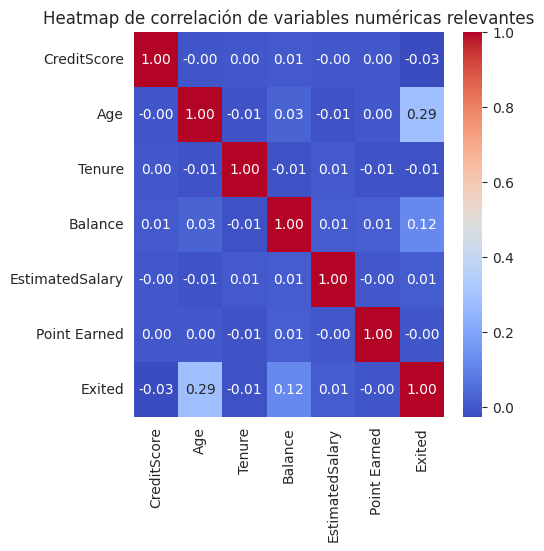

In [ ]:
# 1. Variables num√©ricas relevantes
relevant_numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned', 'Exited']

# 2. Data Frame nuevo
df_relevant_numerics = df[relevant_numerical_columns]

# 3. Matriz de correlaci√≥n de Pearson
correlation_matrix = df_relevant_numerics.corr()

# 4. Heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de correlaci√≥n de variables num√©ricas relevantes")
plt.show()

**Observaciones**

Se puede observar que las √∫nicas variables que presentan un grado de correlaci√≥n con la variable de salida **Exited** son **Age y Balance**, correctamente exploradas con anterioridad.

A su vez, se verifica la **ausencia de multicolinealidad** entre las variables mencionadas.

# **Conclusiones del EDA**

## Las variables **Complain - Is Active Member - Age - Num of Products - Balance - Gender - Geography** se podr√≠an considerar **Variables Predictoras**, mientras que **Has Card** parece no guardar relaci√≥n con el abandono, de acuerdo con la prueba de Cramer¬¥s

# **3. Preprocesamiento de Datos**

## Preparado de los datos para que puedan ser utilizados por los modelos de Machine Learning.

## 3.1. Eliminaci√≥n de las variables irrelevantes

In [ ]:
# Lista de variables irrelevantes para eliminar
variables_irrelevantes = ['RowNumber', 'CustomerId', 'Surname']

# Eliminar las columnas del DataFrame de manera permanente
# La adici√≥n de errors='ignore' previene errores si la columna no existe
df.drop(columns=variables_irrelevantes, inplace=True, errors='ignore')

# 1. Contar el n√∫mero total de variables que quedan
num_total_variables = df.shape[1]

# 2. Contar variables categ√≥ricas (object) y codificadas (int64, float64)
# Excluimos la variable objetivo 'Exited' del conteo
num_categoricas_object = df.select_dtypes(include=['object']).columns.size
num_numericas = df.select_dtypes(include=['int64', 'float64']).columns.size - 1

# 3. Imprimir el recuento
print("Columnas del DataFrame despu√©s de la eliminaci√≥n:")
print(df.columns)
print("-" * 50)
print("N√∫mero de variables para el modelado:")
print(f"Total de variables: {num_total_variables}")
print(f"Variables categ√≥ricas (object): {num_categoricas_object}")
print(f"Variables num√©ricas y categ√≥ricas codificadas: {num_numericas}")

Columnas del DataFrame despu√©s de la eliminaci√≥n:
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')
--------------------------------------------------
N√∫mero de variables para el modelado:
Total de variables: 15
Variables categ√≥ricas (object): 3
Variables num√©ricas y categ√≥ricas codificadas: 11


## 3.2. Feature Engineering
El valor de 0 en la variable **Balance** es at√≠pico por la cantidad de observaciones, no por ser un valor extremo aislado. Representa un estado particular del cliente (**sin saldo**), que puede ser un fuerte predictor de abandono.

Crear una variable binaria (**Balance_Zero**) permite a los modelos de machine learning capturar esta informaci√≥n de manera m√°s directa y efectiva. En lugar de interpretar el 0 de Balance como simplemente un valor num√©rico, el modelo ahora puede usar una caracter√≠stica categ√≥rica que dice **"el cliente no tiene saldo"**.

In [ ]:
# Crear una nueva columna binaria llamada 'Balance_Zero'
# Esta columna tendr√° un 1 si el saldo es 0 y un 0 en cualquier otro caso
df['Balance_Zero'] = (df['Balance'] == 0).astype(int)

# Opcional: mostrar las primeras filas del DataFrame para verificar el cambio
print("Primeras 5 filas del DataFrame con la nueva columna 'Balance_Zero':")
print(df.head())

Primeras 5 filas del DataFrame con la nueva columna 'Balance_Zero':
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  \
0          1               1        101348.88       1         1   
1          0               1        112542.58       0         1   
2          1               0        113931.57       1         1   
3          0               0         93826.63       0         0   
4          1               1         79084.10       0         0   

   Satisfaction Score Card Type  Point Earned  Balance_Zero  
0               

# **4. Modelado y Evaluaci√≥n**

## **Modelos de Machine Learning**
## **Regresi√≥n Log√≠stica |k-NN | Random Forest | Light GBM | XGBoost**

Para el entrenamiento de los modelos propuestos **Regresi√≥n Log√≠stica, k-NN, Random Forest, LightGBM y XGBoost** se ha establecido el **AUC (√Årea bajo la Curva ROC)** como la **m√©trica** principal de comparaci√≥n. Esta elecci√≥n se basa en tres fundamentos claves:

**Insensibilidad al Desbalance:** A diferencia de la precisi√≥n, que puede ser enga√±osamente alta en datasets desequilibrados, el AUC es una m√©trica insensible al desbalance de clases, lo cual es cr√≠tico para nuestro problema de predicci√≥n de abandono.

**Capacidad de Discriminaci√≥n:** El AUC eval√∫a la capacidad del modelo para distinguir entre clases, independientemente del umbral de clasificaci√≥n elegido. Esto nos permite comparar modelos de manera justa.

**Superaci√≥n del Bajo Recall:** El recall para la clase minoritaria (clientes que abandonan) tiende a ser bajo en datasets desequilibrados. El AUC ofrece una visi√≥n m√°s completa del rendimiento del modelo sin verse penalizado por este factor.


**Evaluaci√≥n y Optimizaci√≥n del Modelo**

**Validaci√≥n Cruzada**

Para asegurar que nuestros resultados sean confiables y que los modelos tengan una s√≥lida **capacidad de generalizaci√≥n**, se ha optado por la validaci√≥n cruzada como el m√©todo principal de entrenamiento y evaluaci√≥n. Aunque una divisi√≥n simple en entrenamiento y prueba es √∫til, su rendimiento puede depender de una partici√≥n aleatoria "afortunada" o "desafortunada" de los datos.

En contraste, la validaci√≥n cruzada es una t√©cnica m√°s **robusta**. Se divide el conjunto de entrenamiento en m√∫ltiples subconjuntos **(k-folds)**, y el modelo se entrena y valida **k** veces, utilizando cada k-fold como conjunto de prueba una vez. Este proceso exhaustivo no solo nos proporciona una estimaci√≥n de rendimiento m√°s **confiable y estable**, sino que tambi√©n reduce el riesgo de **sobreajuste**, garantizando que el modelo funcionar√° de manera efectiva con datos nuevos y no vistos.


## 4.1. Separaci√≥n en datos de entrenamiento y prueba

Para garantizar una evaluaci√≥n justa y robusta de los modelos, la metodolog√≠a de preprocesamiento se ha dise√±ado para evitar el **filtrado de datos** (data leakage) y optimizar el rendimiento de cada algoritmo.

**Divisi√≥n de los Datos (train_test_split)**: La primera y √∫nica divisi√≥n de los datos en conjuntos de entrenamiento y prueba se realizar√° al inicio de la etapa de modelado. Esto garantiza que el conjunto de prueba permanezca completamente aislado, sirviendo como una fuente de datos "no vistos" para una evaluaci√≥n final y honesta del rendimiento de cada modelo.



In [ ]:
# El df es el DataFrame luego de la limpieza y el feature engineering
# Se definen las variables predictoras (X) y la variable objetivo (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

# Realizar la divisi√≥n de datos
# test_size=0.2 asigna el 20% de los datos al conjunto de prueba
# random_state=42 asegura que los resultados sean reproducibles
# stratify=y mantiene la misma proporci√≥n de la variable 'Exited' en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Imprimir las formas de los conjuntos para verificar la divisi√≥n
print("Forma de los conjuntos de datos despu√©s de la divisi√≥n √∫nica:")
print(f"X_train: {X_train.shape}")
print(X_train.head())
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Forma de los conjuntos de datos despu√©s de la divisi√≥n √∫nica:
X_train: (8000, 15)
      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4791          709     Spain    Male   35       2       0.00              2   
8881          744    France    Male   29       1   43504.42              1   
6166          773    France    Male   64       2  145578.28              1   
4473          646   Germany  Female   29       4  105957.44              1   
854           675    France  Female   57       8       0.00              2   

      HasCrCard  IsActiveMember  EstimatedSalary  Complain  \
4791          1               0        104982.39         0   
8881          1               1        119327.75         0   
6166          0               1        186172.85         0   
4473          1               0         15470.91         0   
854           0               1         95463.29         0   

      Satisfaction Score Card Type  Point Earned  Balance_Zero  
4791    

**Consideraciones en los modelos**

**Integraci√≥n de Pipelines**: Se implementar√°n pipelines personalizados para cada grupo de modelos. Estos son cruciales porque encadenan el preprocesamiento, el balanceo de clases y el entrenamiento del modelo en un solo objeto.

**Codificaci√≥n y Estandarizaci√≥n**: Dentro de cada pipeline, se aplicar√° la codificaci√≥n de variables categ√≥ricas **(One-Hot Encoding)** y la estandarizaci√≥n de variables num√©ricas **(StandardScaler)** solo a los datos de entrenamiento y en modelos que lo requieran. Esta pr√°ctica evita que los transformadores aprendan de la distribuci√≥n de los datos de prueba, previniendo as√≠ el data leakage.

**Balanceo de Clases**: La t√©cnica de balanceo de datos **(SMOTE)** tambi√©n se integrar√° dentro del pipeline. Esto es fundamental para garantizar que el sobremuestreo se aplique de manera segura solo en el conjunto de entrenamiento de cada iteraci√≥n, evitando el sobreajuste y la contaminaci√≥n de los datos de prueba.

## 4.2. Modelos de Machine Learning Cl√°sicos:

Dado que la **Regresi√≥n Log√≠stica** calcula los pesos de las variables predictoras, el rango de las variables debe ser estandarizado, para que no haya un desbalance.

Debido a que **KNN** es un m√©todo basado en el c√°lculo de distancia, tambi√©n su rango debe de ser estandarizado.


- Se establece un **Standar Scaler** para Regresi√≥n Log√≠stica y KNN
- Se aplica en ambos modelos **One-Hot Econding** para codificar variables categ√≥ricas tipo objeto





## 4.2.1 Regresi√≥n log√≠stica + SMOTE + Validaci√≥n cruzada seg√∫n el AUC.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Resultados de la B√∫squeda en la Cuadr√≠cula:
Mejores hiperpar√°metros encontrados: {'classifier__C': 1, 'classifier__penalty': 'l1'}
Mejor AUC promedio en validaci√≥n cruzada: 0.9995


Evaluaci√≥n del Modelo de Regresi√≥n Log√≠stica en el Conjunto de Prueba:
AUC-ROC en test: 0.9988

Informe de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



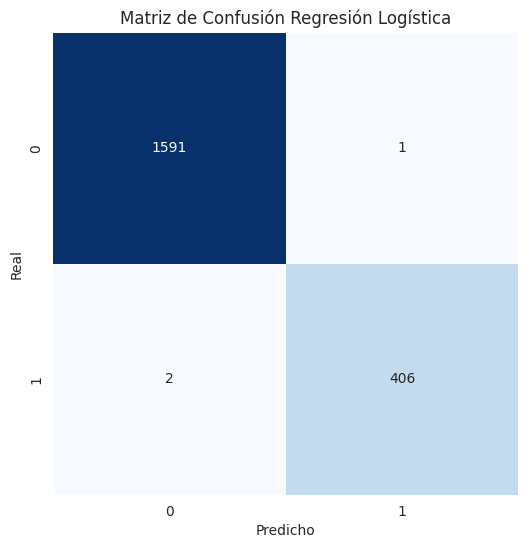

In [ ]:


# 1. Definir las variables para el preprocesamiento

# Variables num√©ricas continuas a escalar
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
# Variables categ√≥ricas tipo 'object' a codificar
categorical_features = ['Geography', 'Gender', 'Card Type']
# Variables categ√≥ricas codificadas num√©ricamente que no se modifican
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']


# 2. Preprocesador para modelos lineales (MLC)

preprocessor_MLC = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


# 3. Pipeline para Regresi√≥n Log√≠stica con SMOTE

# Usamos ImbPipeline para que SMOTE se integre correctamente con GridSearchCV
pipeline_LR = ImbPipeline([
    ('preprocessor', preprocessor_MLC),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])


# 4. B√∫squeda de Hiperpar√°metros con GridSearchCV


# Definir los hiperpar√°metros a buscar
param_grid_LR = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Definir la validaci√≥n cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_LR = GridSearchCV(
    estimator=pipeline_LR,
    param_grid=param_grid_LR,
    scoring='roc_auc',  # Usamos AUC-ROC como m√©trica de evaluaci√≥n principal
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_LR.fit(X_train, y_train)


# 5. Evaluaci√≥n del Mejor Modelo


# Extraer el mejor modelo
best_model_LR = grid_search_LR.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_LR = best_model_LR.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_LR = best_model_LR.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la B√∫squeda en la Cuadr√≠cula:")
print(f"Mejores hiperpar√°metros encontrados: {grid_search_LR.best_params_}")
print(f"Mejor AUC promedio en validaci√≥n cruzada: {grid_search_LR.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluaci√≥n del Modelo de Regresi√≥n Log√≠stica en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_LR):.4f}")
print("\nInforme de Clasificaci√≥n:")
print(classification_report(y_test, y_pred_class_LR))

# Visualizar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_class_LR)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusi√≥n Regresi√≥n Log√≠stica')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.2.2 K-NN + SMOTE + Validaci√≥n cruzada seg√∫n el AUC.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Resultados de la B√∫squeda en la Cuadr√≠cula para KNN:
Mejores hiperpar√°metros encontrados: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Mejor AUC promedio en validaci√≥n cruzada: 0.9620


Evaluaci√≥n del Modelo KNN en el Conjunto de Prueba:
AUC-ROC en test: 0.9698

Informe de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1592
           1       0.72      0.93      0.81       408

    accuracy                           0.91      2000
   macro avg       0.85      0.92      0.88      2000
weighted avg       0.93      0.91      0.91      2000



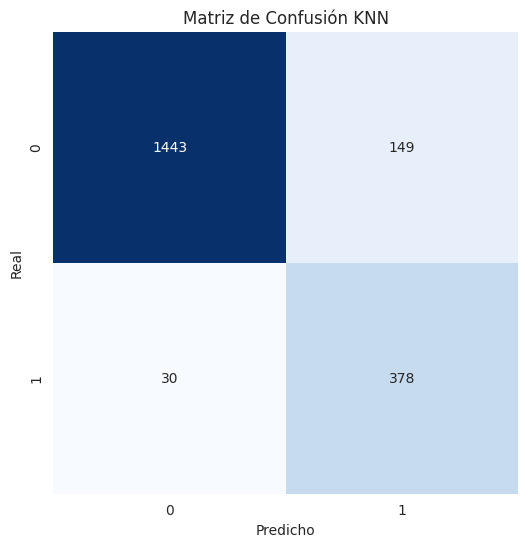

In [ ]:

# 1. Definir las variables para el preprocesamiento
# Usamos las mismas listas de variables, ya que el preprocesamiento es similar
# para KNN y Regresi√≥n Log√≠stica
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']


# 2. Preprocesador para modelos lineales y basados en distancia

preprocessor_MLC = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


# 3. Pipeline para KNN con SMOTE

pipeline_KNN = ImbPipeline([
    ('preprocessor', preprocessor_MLC),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# 4. B√∫squeda de Hiperpar√°metros con GridSearchCV

# Definir los hiperpar√°metros a buscar para KNN
param_grid_KNN = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Definir la validaci√≥n cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_KNN = GridSearchCV(
    estimator=pipeline_KNN,
    param_grid=param_grid_KNN,
    scoring='roc_auc',  # Usamos AUC-ROC como m√©trica de evaluaci√≥n
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
# Aseg√∫rate de que X_train y y_train est√©n disponibles en el entorno
grid_search_KNN.fit(X_train, y_train)




# Extraer el mejor modelo
best_model_KNN = grid_search_KNN.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_KNN = best_model_KNN.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_KNN = best_model_KNN.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la B√∫squeda en la Cuadr√≠cula para KNN:")
print(f"Mejores hiperpar√°metros encontrados: {grid_search_KNN.best_params_}")
print(f"Mejor AUC promedio en validaci√≥n cruzada: {grid_search_KNN.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluaci√≥n del Modelo KNN en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_KNN):.4f}")
print("\nInforme de Clasificaci√≥n:")
print(classification_report(y_test, y_pred_class_KNN))

# Visualizar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_class_KNN)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusi√≥n KNN')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3. Modelos de Machine Learning Avanzados:

En cuanto a los modelos **Light GBM, XGBoost y Random Forest** se destacan los siguientes tratamientos:

- Los modelos no necesitan del escalado de variables.
- Se aplica  **One-Hot Econding** para codificar variables categ√≥ricas tipo objeto

## 4.3.1 Light GBM + SMOTE + Validaci√≥n cruzada seg√∫n el AUC.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4856
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

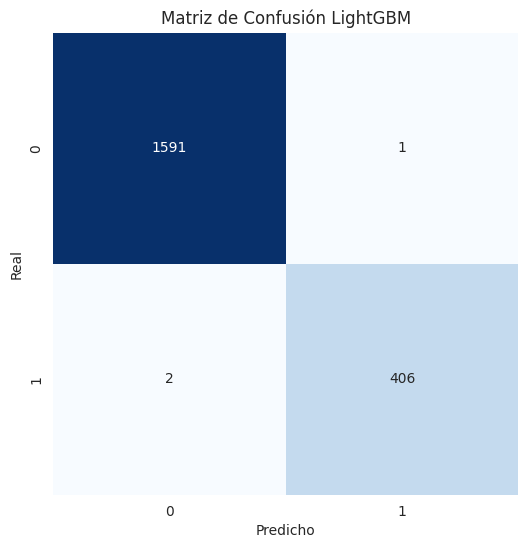

In [ ]:

# 1. Definir las variables para el preprocesamiento

# La misma clasificaci√≥n de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']



# 2. Preprocesador para modelos de √°rboles (MLA)

# LightGBM no necesita escalado. Unicamente se codifican las variables categ√≥ricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)



# 3. Pipeline para LightGBM con SMOTE

pipeline_LGBM = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])



# 4. B√∫squeda de Hiperpar√°metros con GridSearchCV

# Definir los hiperpar√°metros a buscar para LightGBM
param_grid_LGBM = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__num_leaves': [31, 50, 70]
}

# Definir la validaci√≥n cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_LGBM = GridSearchCV(
    estimator=pipeline_LGBM,
    param_grid=param_grid_LGBM,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_LGBM.fit(X_train, y_train)



# 5. Evaluaci√≥n del Mejor Modelo

# Extraer el mejor modelo
best_model_LGBM = grid_search_LGBM.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_LGBM = best_model_LGBM.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_LGBM = best_model_LGBM.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la B√∫squeda en la Cuadr√≠cula para LightGBM:")
print(f"Mejores hiperpar√°metros encontrados: {grid_search_LGBM.best_params_}")
print(f"Mejor AUC promedio en validaci√≥n cruzada: {grid_search_LGBM.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluaci√≥n del Modelo LightGBM en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_LGBM):.4f}")
print("\nInforme de Clasificaci√≥n:")
print(classification_report(y_test, y_pred_class_LGBM))

# Visualizar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_class_LGBM)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusi√≥n LightGBM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3.2 XGBoost + SMOTE + Validaci√≥n cruzada seg√∫n el AUC.

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Resultados de la B√∫squeda en la Cuadr√≠cula para XGBoost:
Mejores hiperpar√°metros encontrados: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Mejor AUC promedio en validaci√≥n cruzada: 0.9996


Evaluaci√≥n del Modelo XGBoost en el Conjunto de Prueba:
AUC-ROC en test: 0.9995

Informe de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



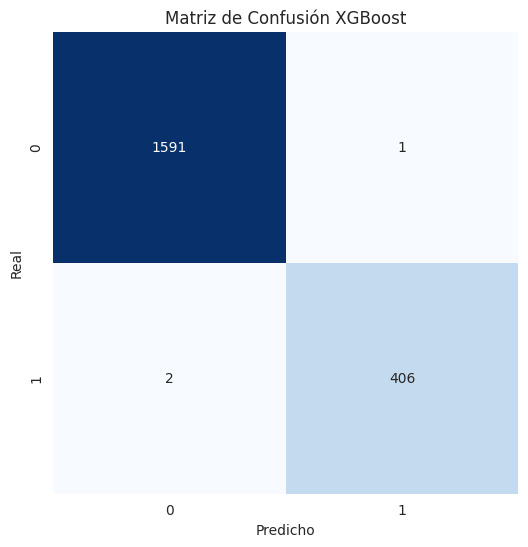

In [ ]:
# 1. Definir las variables para el preprocesamiento

# La misma clasificaci√≥n de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']

# 2. Preprocesador para modelos de √°rboles (MLA)

# XGBoost no necesita escalado. √önicamente se codifican las variables categ√≥ricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 3. Pipeline para XGBoost con SMOTE
from xgboost import XGBClassifier

pipeline_XGB = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42,
        use_label_encoder=False,   # evita warnings de versiones antiguas
        eval_metric='logloss'      # m√©trica recomendada para evitar warning
    ))
])

# 4. B√∫squeda de Hiperpar√°metros con GridSearchCV

# Definir los hiperpar√°metros a buscar para XGBoost
param_grid_XGB = {
    'classifier__n_estimators': [100, 200, 400],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    # Opcionales (regularizaci√≥n):
    # 'classifier__reg_lambda': [1.0, 2.0, 5.0],
    # 'classifier__min_child_weight': [1, 3, 5]
}

# Definir la validaci√≥n cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_XGB = GridSearchCV(
    estimator=pipeline_XGB,
    param_grid=param_grid_XGB,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search_XGB.fit(X_train, y_train)

# 5. Evaluaci√≥n del Mejor Modelo

# Extraer el mejor modelo
best_model_XGB = grid_search_XGB.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_XGB = best_model_XGB.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_XGB = best_model_XGB.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la B√∫squeda en la Cuadr√≠cula para XGBoost:")
print(f"Mejores hiperpar√°metros encontrados: {grid_search_XGB.best_params_}")
print(f"Mejor AUC promedio en validaci√≥n cruzada: {grid_search_XGB.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluaci√≥n del Modelo XGBoost en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_XGB):.4f}")
print("\nInforme de Clasificaci√≥n:")
print(classification_report(y_test, y_pred_class_XGB))

# Visualizar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_class_XGB)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusi√≥n XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.3.3 Random Forest + SMOTE + Validaci√≥n cruzada seg√∫n el AUC.

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Resultados de la B√∫squeda en la Cuadr√≠cula para Random Forest:
Mejores hiperpar√°metros encontrados: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mejor AUC promedio en validaci√≥n cruzada: 0.9996


Evaluaci√≥n del Modelo Random Forest en el Conjunto de Prueba:
AUC-ROC en test: 0.9983

Informe de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



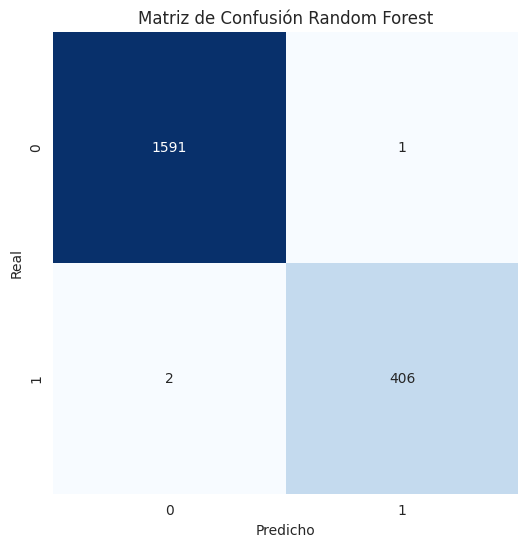

In [ ]:

# 1. Definir las variables para el preprocesamiento

# La misma clasificaci√≥n de variables
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']
passthrough_features = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Balance_Zero']



# 2. Preprocesador para modelos de √°rboles (MLA)

# Random Forest no necesita escalado. Unicamente se codifican las variables categ√≥ricas.
preprocessor_MLA = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)



# 3. Pipeline para Random Forest con SMOTE

pipeline_RF = ImbPipeline([
    ('preprocessor', preprocessor_MLA),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])



# 4. B√∫squeda de Hiperpar√°metros con GridSearchCV

# Definir los hiperpar√°metros a buscar para Random Forest
param_grid_RF = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10]
}

# Definir la validaci√≥n cruzada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el objeto GridSearchCV
grid_search_RF = GridSearchCV(
    estimator=pipeline_RF,
    param_grid=param_grid_RF,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

# Ajustar GridSearchCV a los datos de entrenamiento
# Aseg√∫rate de que X_train y y_train est√©n disponibles en el entorno
grid_search_RF.fit(X_train, y_train)


# 5. Evaluaci√≥n del Mejor Modelo

# Extraer el mejor modelo
best_model_RF = grid_search_RF.best_estimator_

# Predecir las probabilidades en el conjunto de prueba
y_pred_prob_RF = best_model_RF.predict_proba(X_test)[:, 1]

# Predecir las clases en el conjunto de prueba
y_pred_class_RF = best_model_RF.predict(X_test)

# Mostrar los resultados
print("\n" + "="*50 + "\n")
print("Resultados de la B√∫squeda en la Cuadr√≠cula para Random Forest:")
print(f"Mejores hiperpar√°metros encontrados: {grid_search_RF.best_params_}")
print(f"Mejor AUC promedio en validaci√≥n cruzada: {grid_search_RF.best_score_:.4f}")
print("\n" + "="*50 + "\n")
print("Evaluaci√≥n del Modelo Random Forest en el Conjunto de Prueba:")
print(f"AUC-ROC en test: {roc_auc_score(y_test, y_pred_prob_RF):.4f}")
print("\nInforme de Clasificaci√≥n:")
print(classification_report(y_test, y_pred_class_RF))

# Visualizar la matriz de confusi√≥n
cm = confusion_matrix(y_test, y_pred_class_RF)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusi√≥n Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## 4.4. Tabla de resultados

In [ ]:
# Datos de los modelos
data = {
    'Modelo': ['Regresi√≥n Log√≠stica', 'KNN', 'LightGBM','XGBoost', 'Random Forest'],
    'AUC-ROC': [0.9988, 0.9698, 0.9980,0.9995, 0.9983]
}

# Crear el DataFrame
df_resultados = pd.DataFrame(data)

# Ordenar el DataFrame de forma descendente por la m√©trica AUC-ROC
# Para ordenar de mejor a peor, se usa ascending=False
df_resultados = df_resultados.sort_values(by='AUC-ROC', ascending=False)

# Mostrar la tabla
print("Tabla de Comparaci√≥n de Modelos (ordenada por AUC-ROC):")
print(df_resultados)

Tabla de Comparaci√≥n de Modelos (ordenada por AUC-ROC):
                Modelo  AUC-ROC
3              XGBoost   0.9995
0  Regresi√≥n Log√≠stica   0.9988
4        Random Forest   0.9983
2             LightGBM   0.9980
1                  KNN   0.9698


#  **5. Interpretabilidad de los Modelos**

En esta secci√≥n se mostrar√° el aporte de cada variable a la predicci√≥n mediante el uso **SHAP Values**. Se pretende asi buscar saber cuan responsable es cada variable sobre la predcci√≥n del abandono.

- El **Bar Plot** refleja la importancia relativa de las variables ante el abandono.
- El **Summary** refleja el impacto de la variable en la clase positiva

**Machine Learning Avanzados**

## 5.1. XGBoost SHAP Values

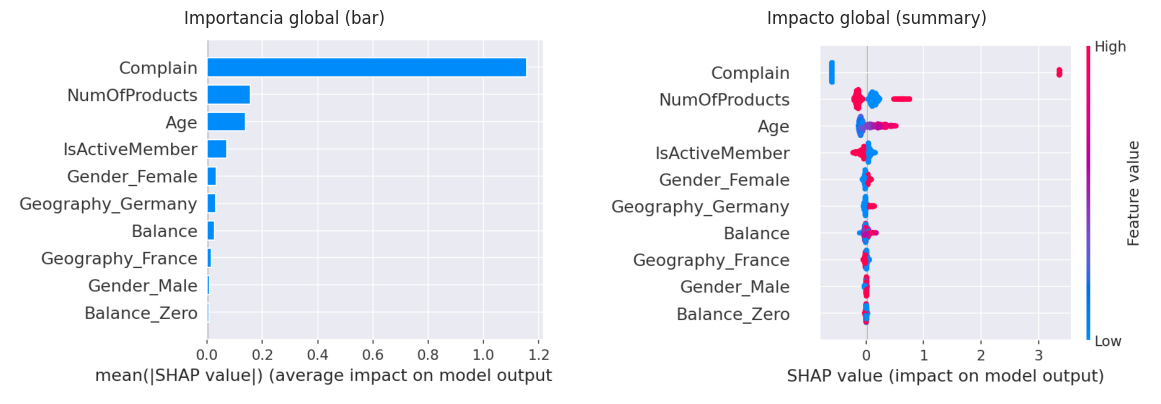

In [ ]:


# 0) Tomar el mejor pipeline entrenado
pipe = best_model_XGB  # pipeline ganador

# 1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

# 2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

#3) Explainer SHAP
model = pipe.named_steps['classifier']
# Para modelos de √°rboles (RF/LGBM/XGB), el Explainer detecta TreeExplainer internamente
explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si est√° (1); si no, tomar la √∫ltima como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

#4) Guardar gr√°ficos por separado con tama√±o controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# Bar plot
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# Summary plot
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

# 5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**:

**Bar Plot**
- La variable **Complain** domina fuertemente en importancia (1,18 aprox), seguido por **Num of Products** (0,16 aprox) , **Age** (0,15 aprox) e **Is Active Member**(0,09 aprox)

**Impacto y direcci√≥n**
- **Complain** tiene un impacto muy alto: Valores muy altos **(en rojo)** impulsan la salida al abandono **(3,2 aprox)** y valores muy bajos **(en azul)** impulsan a permanecer en el banco **(clase negativa)** en menor medida **(-0.5 aprox)**

**Bajo impacto**
- **Num of Products**: El efecto es menos estable (algunos clientes con muchos productos se quedan, otros se van ‚Üí nube m√°s dispersa)
- **Age**: Los clientes de mediana y mayor edad tienden a irse , los de baja edad tienden a quedarse
- **Is Active Member**: Los miembros con baja actividad suelen irse.
- **Geography, Balance y Gender** tienen menos pesos y menor influencia

## 5.2. Random Forest SHAP Values

 99%|===================| 3963/4000 [01:45<00:00]       

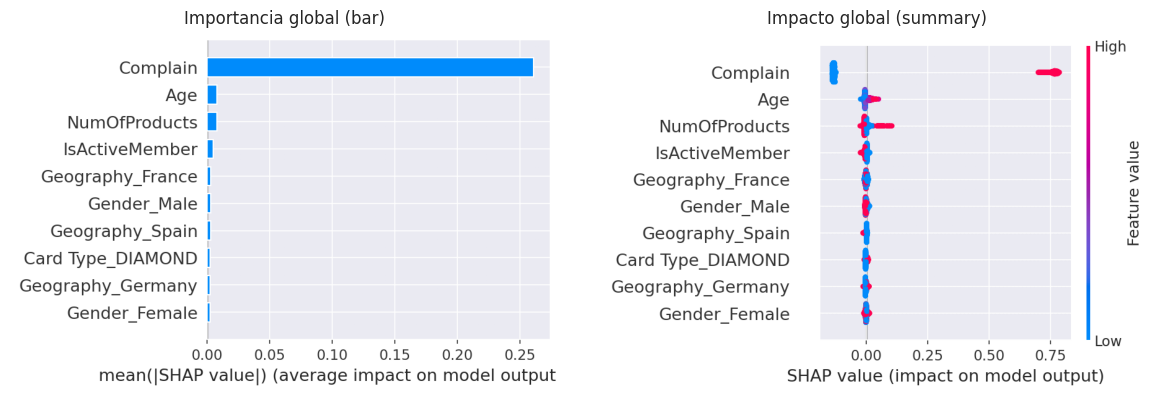

In [ ]:
#0) Tomar el mejor pipeline entrenado
pipe = best_model_RF  # <- tu pipeline ganador (RF)

#1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

# 2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

#3) Explainer SHAP
model = pipe.named_steps['classifier']
# Para modelos de √°rboles (RF/LGBM/XGB), el Explainer detecta TreeExplainer internamente
explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si est√° (1); si no, tomar la √∫ltima como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

#4) Guardar gr√°ficos por separado con tama√±o controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# -- Bar plot
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# -- Summary plot
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

#5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**

**Bar plot:**
- Otra vez **Complain** domina con gran diferencia.
- Variables como  **(Age, NumOfProducts, IsActiveMember, etc)** aparecen pero con valores relativos mas bajos.

**Impacto y direcci√≥n:**

- El impacto de **Complain** es pr√°cticamente determinante: cuando el cliente se queja (alto valor), empuja la predicci√≥n fuertemente hacia la clase positiva.
- **Age y NumOfProducts** destacan sus aportes a la clase positiva, pero con un impacto menor

**Otras variables apenas dispersan alrededor de cero ‚Üí el modelo casi decide todo en funci√≥n de Complain.**

## 5.3. Light GBM SHAP Values

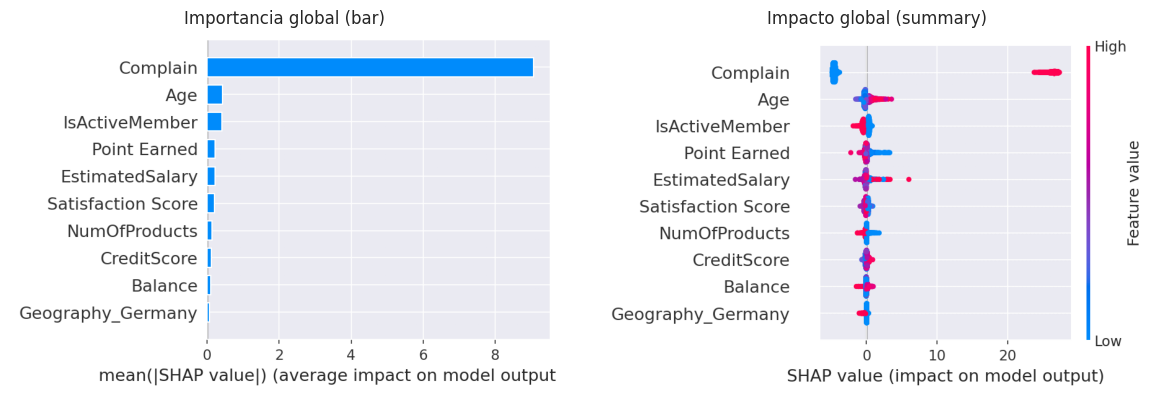

In [ ]:

# 0) Tomar el mejor pipeline entrenado
pipe = best_model_LGBM  # <- tu pipeline ganador (LGBM).

#  1) Transformar TRAIN y TEST con el preprocesador
# (Usamos TRAIN como background para el explainer: evita shape mismatches)
X_train_pre = pipe.named_steps['preprocessor'].transform(X_train)
X_test_pre  = pipe.named_steps['preprocessor'].transform(X_test)

# Convertir a array denso float64 si es necesario
def _to_dense_float(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return X.astype(np.float64)

X_train_pre = _to_dense_float(X_train_pre)
X_test_pre  = _to_dense_float(X_test_pre)

#2) Nombres de variables (limpios)
try:
    feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
    feature_names = [n.replace("remainder__", "").replace("cat__", "") for n in feature_names]
except Exception:
    feature_names = None

# 3) Explainer SHAP
model = pipe.named_steps['classifier']

explainer = shap.Explainer(model, X_train_pre)     # <<--- background = TRAIN ya preprocesado
shap_expl = explainer(X_test_pre)                  # Devuelve un shap.Explanation

# Extraer matriz de valores (maneja binario/multiclase de forma segura)
# - Binario: shap_expl.values -> (n_samples, n_features)
# - Multiclase: (n_samples, n_features, n_classes) -> tomamos la clase positiva (1) si existe
values = shap_expl.values
if values.ndim == 3:
    # elegir clase positiva si est√° (1); si no, tomar la √∫ltima como fallback
    if model.classes_.shape[0] > 1:
        import numpy as np
        if 1 in model.classes_:
            pos_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            pos_idx = -1
    else:
        pos_idx = -1
    values = values[:, :, pos_idx]

# 4) Guardar gr√°ficos por separado con tama√±o controlado
bar_path = "shap_bar_rf.png"
sum_path = "shap_summary_rf.png"

# -- Bar plot --
plt.figure()
shap.summary_plot(
    values,                 # matriz (n_samples, n_features)
    X_test_pre,             # datos ya preprocesados
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    max_display=10,
    plot_size=(6, 4)        # ancho, alto en pulgadas
)
plt.tight_layout()
plt.savefig(bar_path, dpi=150, bbox_inches="tight")
plt.close()

# -- Summary plot --
plt.figure()
shap.summary_plot(
    values,
    X_test_pre,
    feature_names=feature_names,
    show=False,
    max_display=10,
    plot_size=(6, 4)
)
plt.tight_layout()
plt.savefig(sum_path, dpi=150, bbox_inches="tight")
plt.close()

#  5) Componer lado a lado en una sola figura
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(plt.imread(bar_path))
axes[0].set_title("Importancia global (bar)")
axes[0].axis("off")

axes[1].imshow(plt.imread(sum_path))
axes[1].set_title("Impacto global (summary)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**Observaciones**

**Bar plot:**

- Tambi√©n resalta **Complain** como primer variable de importancia ante el abandono
- Se aprecian variables como **Age, Is Active Member, Point Earned, Estimated Salary y dem√°s** pero con una baja importancia relativa .

**Impacto y direcci√≥n:**

- **Complain** sigue siendo la m√°s influyente, pero con mayor impacto en el abandono (25) que en XGBoost(3.2) y Random Forest(0.75).
- Los clientes de mediana y mayor edad tienden a abandonar.
- Los clientes inactivos tienden a abandonar
- **Point Earned y Estimated Salary** toman valor en el impacto

**Se observa una cierta dispersi√≥n en la decisi√≥n**

**Machine Learning Cl√°sicos**

In [ ]:
def prepare_X_and_names(pipe, X):
    """Transforma X con el preprocesador del pipeline y devuelve datos densos + nombres limpios."""
    X_pre = pipe.named_steps['preprocessor'].transform(X)
    if hasattr(X_pre, "toarray"):
        X_pre = X_pre.toarray()
    X_pre = X_pre.astype(np.float64)
    try:
        names = pipe.named_steps['preprocessor'].get_feature_names_out()
        names = [n.replace("remainder__", "")
                   .replace("cat__", "")
                   .replace("num__", "")   # üîπ Nuevo: elimina el prefijo num__
                 for n in names]
    except:
        names = None
    return X_pre, names

def plot_shap_side_by_side(values, X_pre, feature_names, prefix="model", max_display=10):
    """Genera bar + summary en PNGs chicos y los compone lado a lado."""
    bar_path = f"shap_bar_{prefix}.png"
    sum_path = f"shap_summary_{prefix}.png"

    # Bar
    plt.figure()
    shap.summary_plot(values, X_pre, feature_names=feature_names,
                      plot_type="bar", show=False, max_display=max_display, plot_size=(6,4))
    plt.tight_layout(); plt.savefig(bar_path, dpi=150, bbox_inches="tight"); plt.close()

    # Summary
    plt.figure()
    shap.summary_plot(values, X_pre, feature_names=feature_names,
                      show=False, max_display=max_display, plot_size=(6,4))
    plt.tight_layout(); plt.savefig(sum_path, dpi=150, bbox_inches="tight"); plt.close()

    # Componer
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].imshow(plt.imread(bar_path)); axes[0].set_title("Importancia global (bar)"); axes[0].axis("off")
    axes[1].imshow(plt.imread(sum_path)); axes[1].set_title("Impacto global (summary)"); axes[1].axis("off")
    plt.tight_layout(); plt.show()

## 5.4. Regresi√≥n Log√≠stica SHAP Values

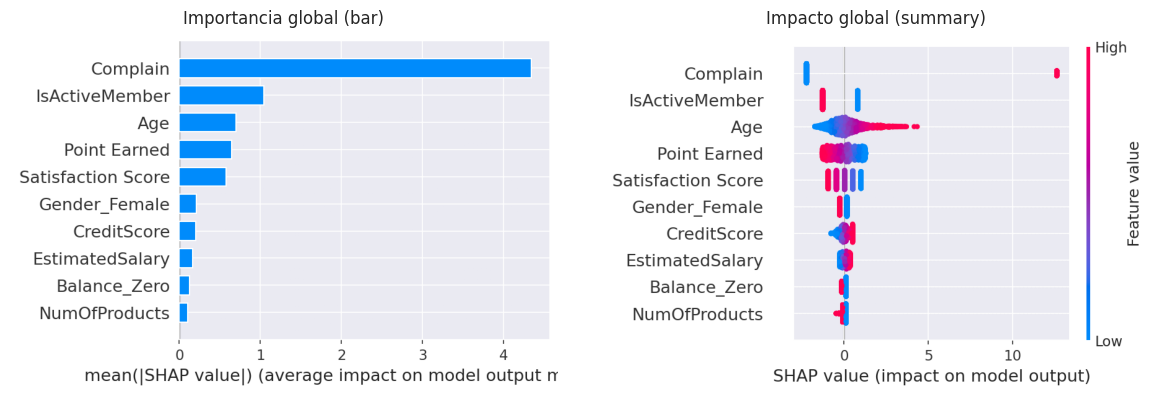

In [ ]:


#  1) Elegir pipeline ganador
pipe = best_model_LR

#  2) Preparar TRAIN y TEST preprocesados + nombres
X_train_pre, _           = prepare_X_and_names(pipe, X_train)   # background
X_test_pre, feature_names = prepare_X_and_names(pipe, X_test)

# 3) Explainer (lineal) y valores SHAP
model = pipe.named_steps['classifier']
explainer = shap.LinearExplainer(model, X_train_pre)  # background = train preprocesado
shap_values = explainer.shap_values(X_test_pre)       # matriz (n_samples, n_features)

# 4) Graficar (bar + summary) lado a lado
plot_shap_side_by_side(shap_values, X_test_pre, feature_names, prefix="logistic", max_display=10)

**Observaciones**

**Bar plot:**

- **Complain** otra vez lidera, le siguen **IsActiveMember,Age, Point Earned y Satisfaction Score**
- **Num of Products** no fue tomada como variable de gran importancia en relaci√≥n con las anteriormente mencionadas.


**Impacto y direcci√≥n:**

- La variable **Complain** tiene mayor impacto en la salida, seguida de **Is active Member, Age,  Point Earned y Satisfaction Score**.
- Se observa como al **no** ser un miembro activo **Is Active Member = Azul** , el cliente se va.
- Se observa como los clientes de **mayor edad = Rojo** suelen abandonar.
- Se observa como los clientes con menor **puntajes ganados = Azul** (en el uso de la tarjeta) abandonan
- Se observa como los puntajes **bajos de satisfacci√≥n = Azul** tienden a abandonar.
- Se observa que el **Genero femenino** no suele abandonar
- Se observa que **salarios y scores crediticios** altos tienden a abandonar
- Se observa que el **balance en cero y muchas unidades compradas con el banco** no suelen abandonar.

**La contribuci√≥n es m√°s lineal: valores altos/bajos afectan consistentemente hacia arriba o abajo, sin tanta no linealidad como en √°rboles.**

## 5.5. KNN SHAP Values

  0%|          | 0/2000 [00:00<?, ?it/s]

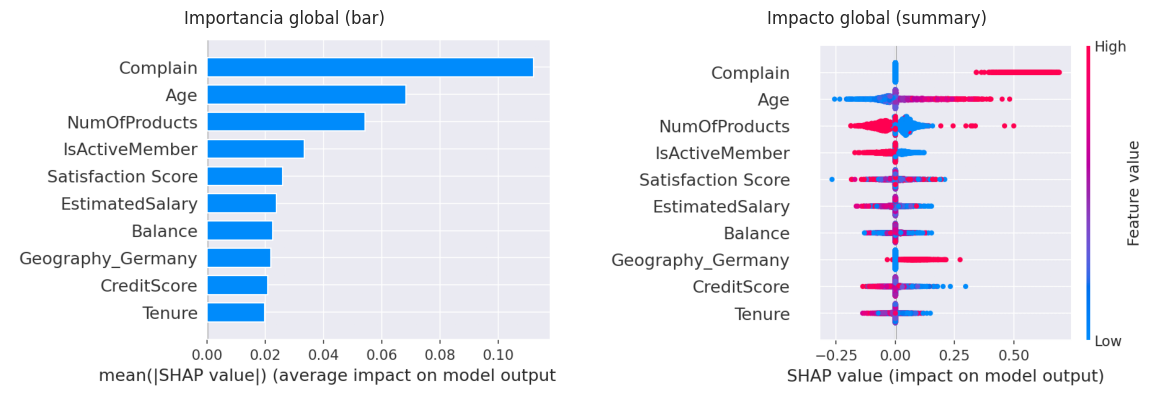

In [ ]:


# 0) Elegir pipeline
pipe = best_model_KNN

# 1) Preparar TRAIN/TEST preprocesados + nombres limpios
X_train_pre, _            = prepare_X_and_names(pipe, X_train)
X_test_pre, feature_names = prepare_X_and_names(pipe,  X_test)

# 2) Background resumido con kmeans (r√°pido/estable)
#    Pod√©s ajustar K (30/50/100) seg√∫n tiempo vs. precisi√≥n
background = shap.kmeans(X_train_pre, 15)

# 3) Funci√≥n de predicci√≥n de prob. para la clase positiva
model = pipe.named_steps['classifier']
f_pos = lambda X: model.predict_proba(X)[:, 1]

# 4) KernelExplainer y c√°lculo de SHAP values
explainer = shap.KernelExplainer(f_pos, background)
# nsamples controla tiempo/precisi√≥n (100 va bien; sub√≠ si pod√©s)
shap_values = explainer.shap_values(X_test_pre, nsamples=100)  # (n_samples, n_features)

# 5) Graficar bar + summary lado a lado con tu helper
plot_shap_side_by_side(shap_values, X_test_pre, feature_names, prefix="knn", max_display=10)

**Observaciones**

**Bar plot:**

- **Complain** vuelve a ser la m√°s importante, pero ahora acompa√±ada de cerca por **Age, NumOfProducts, IsActiveMember, Satisfaction Score** en mayor medida
- La importancia relativa se ve mas **atenuada** para todas las variables

**El KNN reparte la importancia entre m√°s variables**.

**Impacto y direcci√≥n**

- Se observa **dispersi√≥n** en muchas variables, no solo en una.

- Aunque **Complain** sigue arriba, el modelo tambi√©n usa activamente otras dimensiones para diferenciar los casos.

**La escala de los SHAP values es m√°s reducida (impactos m√°s acotados en comparaci√≥n con √°rboles).**

## **Conclusiones de la secci√≥n**

El an√°lisis de **SHAP Values** permiti√≥ comprender de manera detallada c√≥mo cada variable impacta en la predicci√≥n de abandono de clientes, aportando interpretabilidad al desempe√±o de los modelos.

De forma consistente, en todos los algoritmos evaluados se observ√≥ que la variable **Complain** es el predictor m√°s determinante del churn. En modelos de √°rboles como **XGBoost, LightGBM y Random Forest**, su efecto domina casi por completo, mientras que en **Regresi√≥n Log√≠stica y KNN** emergen otras variables con peso considerable.

Entre estas, destacan:

**Age**: los clientes de mayor edad tienden a presentar mayor riesgo de abandono.

**IsActiveMember**: La membres√≠a activa se confirma como un factor protector frente al churn.

**NumOfProducts**: En general , a mayor cantidad de productos contratados se reduce la probabilidad de salida.

**Satisfaction Score y Point Earned**: variables de engagement y fidelizaci√≥n que, si bien no se destacaron en el EDA bivariado, adquieren relevancia en el an√°lisis multivariado.

**Variables financieras (Balance, Estimated Salary, Credit Score)**: muestran impactos m√°s moderados pero consistentes, contribuyendo al entendimiento del perfil del cliente que abandona.

En conclusi√≥n, el uso de **SHAP Values** no solo valid√≥ los hallazgos principales del **EDA** y de la **Regresi√≥n Log√≠stica**, sino que tambi√©n revel√≥ relaciones m√°s complejas, permitiendo diferenciar entre predictores dominantes y variables de soporte. As√≠, se confirma que la queja es el principal disparador del churn, pero que factores de engagement, edad, satisfacci√≥n y fidelizaci√≥n tambi√©n influyen en la permanencia de los clientes.

#  **6. Selecci√≥n del modelo y an√°lisis de los resultados del EDA**

## 6.1. Modelo Seleccionado

Cabe destacar que los valores de **AUC** obtenidos (‚âà0,99) son excepcionalmente altos en comparaci√≥n con lo que suele observarse en problemas de churn reales, donde resultados entre 0,75 y 0,90 ya se consideran satisfactorios. Esto sugiere que el dataset de Kaggle utilizado podr√≠a contener patrones muy marcados o variables con fuerte poder discriminatorio, visto con anterioridad en **SHAP values**, lo que facilita la predicci√≥n. Si bien la validaci√≥n cruzada contribuye a reducir el riesgo de sobreajuste, ser√° fundamental validar el modelo con datos reales de una instituci√≥n bancaria para confirmar la robustez de estos resultados.

De acuerdo al **AUC** de cada uno de los modelos, se puede concluir que la **Regresi√≥n Log√≠stica** es el modelo mas **Simple y Robusto** para esta ocasi√≥n.

Esta elecci√≥n tambi√©n se fundamenta en que los **modelos de arboles**: **XGBoost,Light GBM y Random Forest** se apoyan exclusivamente en la variable **Complain**, mientras que el modelo de **Regresi√≥n Log√≠stica** reparte mejor los pesos de cada variable.

Este criterio **toma valor** en la vida cotidiana, ya que la elecci√≥n de este modelo disminuye el **riesgo** del proyecto si la variable **Complain** falta o cambia en el futuro.

Asi, por **simplicidad y robustez**, el modelo mas acorde a seleccionarse es la **Regresi√≥n Log√≠stica**

## 6.2. An√°lisis de la Regresi√≥n Log√≠stica y confirmaci√≥n de los hallazgos del EDA





En esta secci√≥n, se presenta la validaci√≥n de los hallazgos del an√°lisis exploratorio de datos **(EDA)** a trav√©s del modelado predictivo. A su vez, se demuestra c√≥mo la Regresi√≥n Log√≠stica, con su **capacidad de an√°lisis multivariado**, no solo confirm√≥ la precisi√≥n de nuestras hip√≥tesis iniciales, sino que tambi√©n descubri√≥ relaciones y dependencias m√°s sutiles y complejas que no eran evidentes en un an√°lisis superficial.

Para ello, se evaluar√° la efectividad del modelo bas√°ndonos en dos pilares fundamentales:

**An√°lisis de Coeficientes:** Se mostrar√° el peso asignado por el modelo a cada variable, confirmando la importancia de nuestros hallazgos iniciales y revelando el impacto de otras caracter√≠sticas.

**Validaci√≥n de la Linealidad:** Se demostrar√° visualmente la dependencia lineal entre el logaritmo de las probabilidades (log-odds) de abandono y las variables predictoras clave, validando la suposici√≥n central de la regresi√≥n log√≠stica y explicando su excepcional rendimiento.

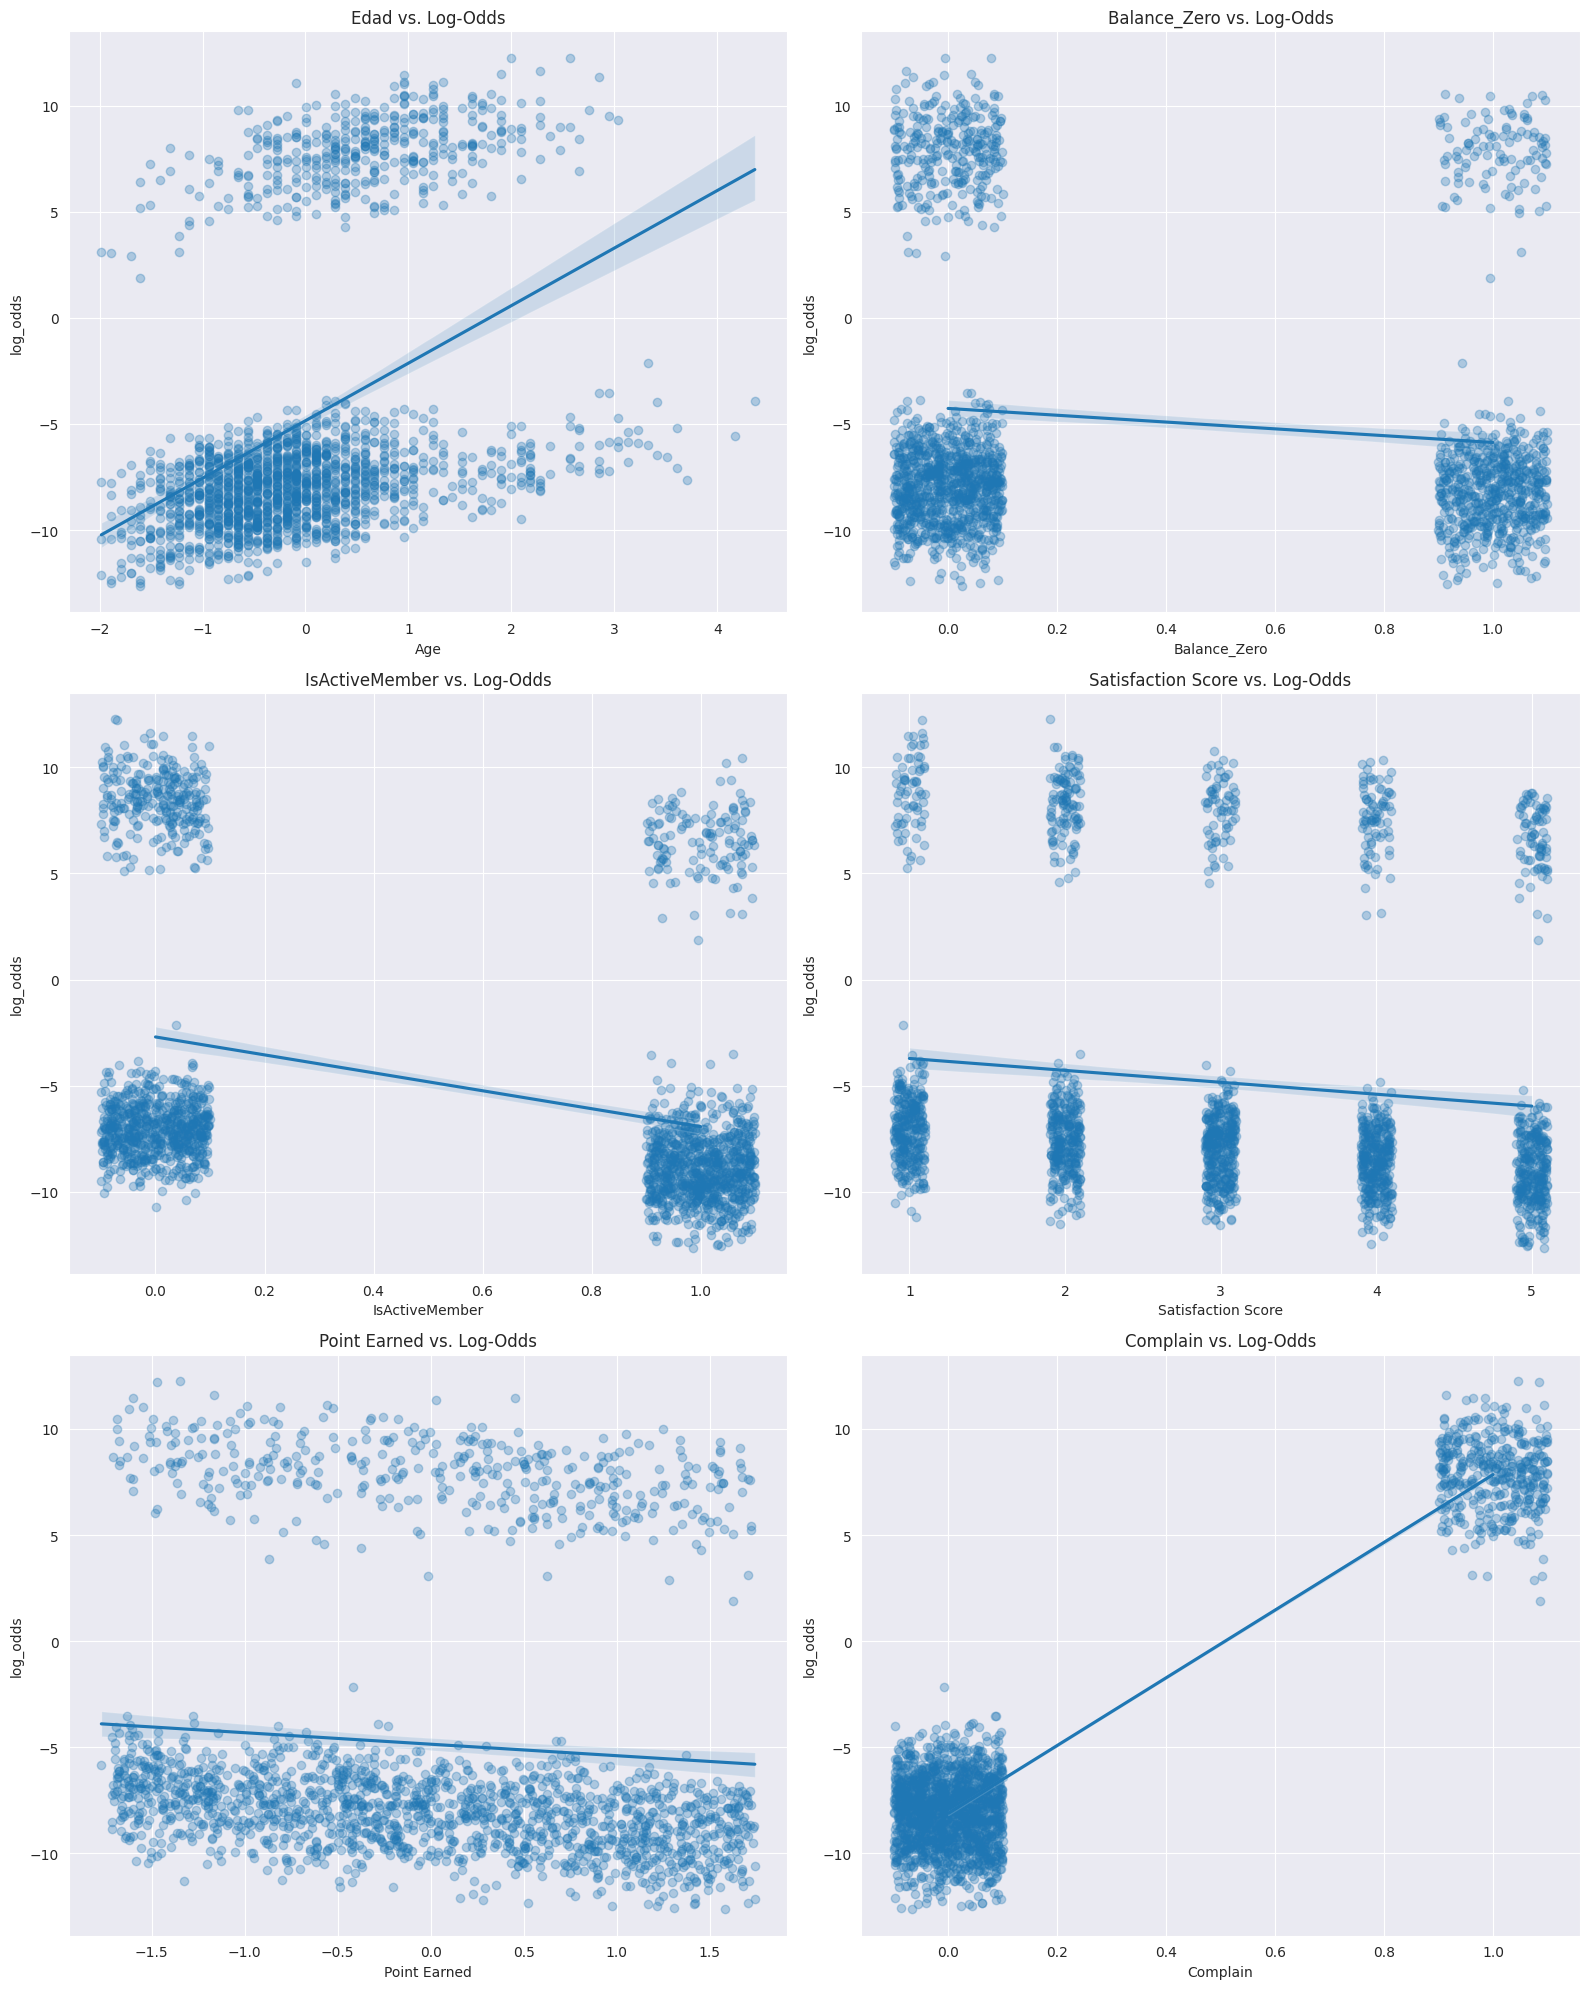

Coeficientes del Modelo (Pesos de las Caracter√≠sticas):
Complain              14.852604
Age                    0.957147
CreditScore            0.248810
EstimatedSalary        0.185301
Tenure                 0.007357
Balance                0.000000
Geography_France       0.000000
Card Type_GOLD         0.000000
Gender_Male            0.000000
Card Type_SILVER       0.000000
HasCrCard              0.000000
Card Type_DIAMOND     -0.032322
Geography_Spain       -0.056656
NumOfProducts         -0.192615
Card Type_PLATINUM    -0.256248
Balance_Zero          -0.256739
Geography_Germany     -0.261908
Gender_Female         -0.424788
Satisfaction Score    -0.486534
Point Earned          -0.744587
IsActiveMember        -2.078437
dtype: float64


In [ ]:

# 1. Transformar los datos de prueba usando el preprocesador del pipeline
preprocessor = best_model_LR.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)

# 2. Obtener el logaritmo de las probabilidades usando el m√©todo decision_function
classifier = best_model_LR.named_steps['classifier']
log_odds = classifier.decision_function(X_test_transformed)

# 3. Crear un DataFrame para los gr√°ficos
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_column_names = numerical_features + list(ohe_feature_names) + passthrough_features

df_analysis = pd.DataFrame(X_test_transformed, columns=new_column_names)
df_analysis['log_odds'] = log_odds
df_analysis['Exited'] = y_test.values

# 4. Crear gr√°ficos de dispersi√≥n para las caracter√≠sticas clave
fig, axes = plt.subplots(3, 2, figsize=(16, 20)) # 3 filas, 2 columnas para 6 gr√°ficos

# Fila 1
sns.regplot(x='Age', y='log_odds', data=df_analysis, ax=axes[0, 0], scatter_kws={'alpha':0.3})
axes[0, 0].set_title('Edad vs. Log-Odds')

sns.regplot(x='Balance_Zero', y='log_odds', data=df_analysis, ax=axes[0, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[0, 1].set_title('Balance_Zero vs. Log-Odds')

# Fila 2
sns.regplot(x='IsActiveMember', y='log_odds', data=df_analysis, ax=axes[1, 0], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[1, 0].set_title('IsActiveMember vs. Log-Odds')

sns.regplot(x='Satisfaction Score', y='log_odds', data=df_analysis, ax=axes[1, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[1, 1].set_title('Satisfaction Score vs. Log-Odds')

# Fila 3
sns.regplot(x='Point Earned', y='log_odds', data=df_analysis, ax=axes[2, 0], scatter_kws={'alpha':0.3})
axes[2, 0].set_title('Point Earned vs. Log-Odds')

sns.regplot(x='Complain', y='log_odds', data=df_analysis, ax=axes[2, 1], x_jitter=.1, scatter_kws={'alpha':0.3})
axes[2, 1].set_title('Complain vs. Log-Odds')

plt.tight_layout()
plt.show()

# 5. Tambi√©n puedes analizar los coeficientes para entender la relaci√≥n lineal
coefficients = pd.Series(classifier.coef_[0], index=new_column_names).sort_values(ascending=False)
print("Coeficientes del Modelo (Pesos de las Caracter√≠sticas):")
print(coefficients)

**Conclusiones del EDA Validadas por los pesos del Modelo**

El modelo de regresi√≥n log√≠stica confirm√≥ que las variables que se identificaron en el **EDA** son las m√°s importantes para predecir el abandono de clientes. Esto permite afirmar con confianza que los hallazgos iniciales **son robustos** y est√°n respaldados por un modelo estad√≠stico avanzado.

- **Variables clave**: Las variables **Complain** (14.85), **Age** (0.95) e **IsActiveMember** (-2.07) mostraron pesos significativos. Su alta contribuci√≥n en el modelo valida la intuici√≥n inicial.

- **Importancia del G√©nero , Geography y NumOfProducts**: El modelo confirm√≥ que el g√©nero es un predictor, con un peso considerable para **Gender_Female (-0.43)**, sugiriendo que, en igualdad de condiciones, las mujeres tienen una menor probabilidad de abandonar.
Por su parte, la geograf√≠a tuvo un peso considerable para el pa√≠s Alem√°n **(Geogaphy_Germany:-0.26)** mientras que haber comprado m√°s productos con el banco disminuye el abandono **(Num of Product: -0.19)**

- **Has Card**: Se busca notar que la variable cumple la hip√≥tesis sugerida por la prueba de Cram√©r's.

- A su vez, si bien **Balance** no presenta un peso considerable , la creaci√≥n de **Balance_zero:-0.25** fue muy importante.

**Se puede apreciar que la ausencia de Geography en SHAPE Values muestra como dicha prueba evalua la importancia relativa al problema de clasificaci√≥n**


**Hallazgos Adicionales Descubiertos por el Modelo - Verificado mediante SHAPE Values**

El modelo de regresi√≥n log√≠stica aport√≥ un valor adicional al proyecto, encontrando variables predictoras importantes en su contexto multvariado.

- **Satisfaction Score (-0.48)**: Aunque no se encontr√≥ una correlaci√≥n fuerte en el EDA, el modelo descubri√≥ que la satisfacci√≥n es un factor clave cuando se considera junto con las otras variables.

- **Point Earned (-0.74) - Credit Score (0.25) - Estimated Salary (0.185)**: Similarmente, los puntos de lealtad resultaron ser un factor de retenci√≥n muy relevante en el modelo. A su vez, el puntaje Crediticio y el salario contribuyeron positivamente al abandono.

- **Balance_Zero (-0.25)**: Esta variable, fruto de la ingenier√≠a de caracter√≠sticas, se convirti√≥ en un predictor valioso, demostrando que tener un saldo cero es m√°s importante para la predicci√≥n que el valor exacto del saldo.

**Verificaci√≥n de la Linealidad del problema**


Para confirmar la **naturaleza lineal** de las relaciones que el modelo de regresi√≥n log√≠stica ha identificado, se comparan los pesos **(coeficientes)** asignados por el modelo a cada caracter√≠stica con el **coeficiente de correlaci√≥n de Pearson** entre las features y el logaritmo de las probabilidades **(log-odds)**. Una fuerte concordancia entre ambas medidas refuerza la validez de la suposici√≥n de linealidad.

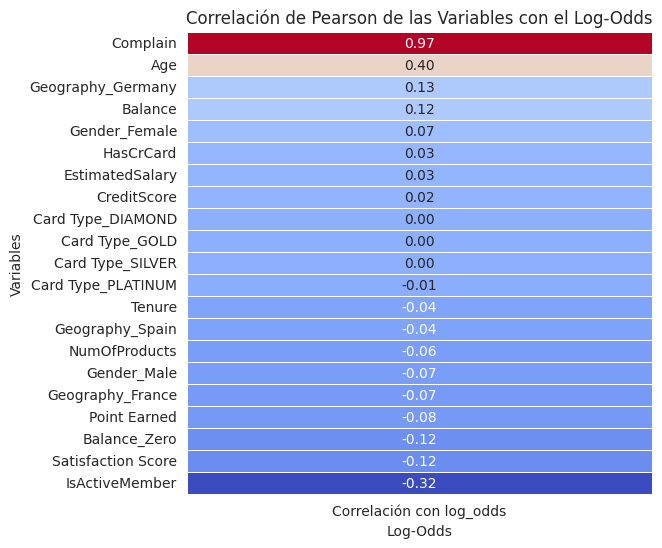

In [ ]:


# Paso 1: Eliminar la columna 'Exited' del DataFrame de an√°lisis
df_corr_analysis = df_analysis.drop(columns=['Exited'])

# Paso 2: Calcular la correlaci√≥n de Pearson de todas las columnas con 'log_odds'
correlations_log_odds = df_corr_analysis.corr()['log_odds'].sort_values(ascending=False)

# Paso 3: Eliminar la correlaci√≥n de 'log_odds' consigo mismo para una mejor visualizaci√≥n
correlations_log_odds = correlations_log_odds.drop('log_odds')

# Paso 4: Convertir la Serie a un DataFrame para el heatmap
df_corr = correlations_log_odds.to_frame(name='Correlaci√≥n con log_odds')

# Paso 5: Visualizar la matriz de correlaci√≥n en un heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
plt.title('Correlaci√≥n de Pearson de las Variables con el Log-Odds')
plt.xlabel('Log-Odds')
plt.ylabel('Variables')
plt.show()

**An√°lisis Comparativo de los pesos y la relaci√≥n lineal con el log-odds**

Observamos una clara alineaci√≥n entre los coeficientes del modelo y la correlaci√≥n de Pearson con el log-odds para las variables m√°s influyentes:

**Complain:**

**Coeficiente del Modelo:** 14.84 (peso extremadamente alto y positivo).

**Correlaci√≥n con Log-Odds:** 0.97 (correlaci√≥n casi perfecta y positiva).

Esta variable presenta la **relaci√≥n lineal** m√°s fuerte y directa con el log-odds de abandono. El modelo le asigna un peso dominante, confirmando su rol cr√≠tico determinado en el **EDA**

**IsActiveMember:**

**Coeficiente del Modelo:** -2.07 (peso muy alto y negativo).

**Correlaci√≥n con Log-Odds:** -0.32 (correlaci√≥n negativa significativa).

Ser un miembro activo reduce dr√°sticamente el log-odds de abandono, con una clara relaci√≥n lineal inversa y siendo v√°lida la capacidad predictiva sugerida por el **EDA**

**Age:**

**Coeficiente del Modelo:** 0.95 (peso alto y positivo).

**Correlaci√≥n con Log-Odds:** 0.40 (correlaci√≥n positiva moderada).

La edad incrementa el log-odds de abandono con una relaci√≥n lineal s√≥lida, validando la tendencia observada en el **EDA**

**Satisfaction Score:**

**Coeficiente del Modelo:** -0.48 (peso negativo).

**Correlaci√≥n con Log-Odds:** -0.12 (correlaci√≥n negativa).

El modelo le otorga un peso significativo a esta variable, indicando una relaci√≥n lineal inversa con el log-odds de abandono que no ser√≠a tan clara con solo la correlaci√≥n. Tambi√©n se observa la capacidad de **an√°lisis multivariado** del modelo, ya que este no hab√≠a sido un hallazgo del **EDA**


**Point Earned:**

**Coeficiente del Modelo:** -0.74 (peso alto y negativo).

**Correlaci√≥n con Log-Odds:**  -0.08 (correlaci√≥n negativa, pero relativamente baja).

A pesar de una correlaci√≥n de Pearson aparentemente d√©bil a nivel **bivariado** con el abandono, el modelo asigna un peso considerable a esta variable. Esto sugiere que su verdadero impacto lineal se manifiesta de manera m√°s pronunciada dentro del contexto **multivariado**, donde su efecto se distingue al controlar otras variables. Este es un ejemplo clave de c√≥mo el modelo revela dependencias no evidentes en un an√°lisis superficial del **EDA**.

**Gender_Female:**

**Coeficiente del Modelo:** -0.43 (peso negativo).

**Correlaci√≥n con Log-Odds:** 0.07 (correlaci√≥n positiva).

Mediante esta variable se puede explicar porque el hallazgo del **EDA** en el contexto **bivariado** sugiere que las mujeres tienden a abandonar, mientras que en el contexto **multivariado**, tienden a quedarse

**Geography_Germany:**

**Coeficiente del Modelo:** -0.26 (peso negativo).

**Correlaci√≥n con Log-Odds:** 0.13 (correlaci√≥n positiva).

Los clientes en Alemania tienen una relaci√≥n lineal inversa con el log-odds de abandono, lo que sugiere que su ubicaci√≥n es un factor de retenci√≥n. Si bien fue considerada variable predictora en el **EDA**, el **SHAPE Values** demostr√≥ que no guardaba importancia relativa con el abandono en este contexto **multivariado**. A su vez, de acuerdo al bar plot del **EDA** se hab√≠a pensado que Alemania era un pa√≠s infiel, lo que no parece ser decretado por el modelo.

**Credit Score:**

**Coeficiente del Modelo:** 0,25 (peso positivo).

**Correlaci√≥n con Log-Odds:** 0.02 (correlaci√≥n positiva).

Los clientes con alto score crediticio tienden a abandonar. Este comportamiento se puede deducir en el **(SHAPE Values)** y no fue determinado en el **EDA**

**Estimated Salary:**

**Coeficiente del Modelo:** 0,184 (peso positivo).

**Correlaci√≥n con Log-Odds:** 0.03 (correlaci√≥n positiva).

Los cientes con alto salario tienden a abandonar.Este comportamiento se puede deducir en el **(SHAPE Values)** y no fue determinado en el **EDA**

**Balance_Zero:**

**Coeficiente del Modelo:** -0.25 (peso negativo).

**Correlaci√≥n con Log-Odds:** -0.12 (correlaci√≥n negativa).

Esta variable, resultado de la ingenier√≠a de las caracter√≠sticas, demuestra una clara relaci√≥n lineal con el log-odds. El modelo confirma que tener un saldo cero tiene un impacto negativo en la probabilidad de abandono, lo que es un hallazgo clave del **EDA**

**NumOfProducts:**

**Coeficiente del Modelo:** -0.18 (peso negativo).

**Correlaci√≥n con Log-Odds:** -0.06 (correlaci√≥n negativa).

El modelo le asigna un peso que confirma la relaci√≥n lineal inversa: a m√°s productos que un cliente tiene, menor es la probabilidad de que abandone. Esta relaci√≥n con el abandono fue otro hallazgo del **EDA**



## **Conclusi√≥n de la secci√≥n**

La comparaci√≥n de modelos permiti√≥ observar dos patrones claros:

**Modelos de √°rboles (XGBoost, Random Forest, LightGBM):** Se apoyan casi exclusivamente en la variable **Complain**, con muy poco aporte del resto de las caracter√≠sticas. Esto los hace menos robustos, ya que dependen de una sola fuente de informaci√≥n.

**Regresi√≥n Log√≠stica:** Reparte los pesos de manera m√°s balanceada, asignando importancia a variables adicionales como **Age, IsActiveMember, NumOfProducts, Satisfaction Score , Point Earned** entre otras.



#  **7.Conclusiones**

El an√°lisis exploratorio de datos **(EDA)** permiti√≥ identificar variables claves relacionadas con el abandono de clientes, destac√°ndose **Complain, Age, IsActiveMember, Balance, NumOfProducts, Gender y Geography** como los principales factores explicativos. Estos hallazgos iniciales fueron posteriormente confirmados y enriquecidos mediante el modelado predictivo.

Al comparar distintos **algoritmos** de clasificaci√≥n, se observ√≥ que todos alcanzaron un desempe√±o muy elevado en t√©rminos de **AUC-ROC** (superior al 0.96 en todos los casos). El modelo con mayor valor de AUC fue **XGBoost (0.9995**), seguido muy de cerca por Regresi√≥n Log√≠stica **(0.9988)**, **Random Forest (0.9983)** y **LightGBM (0.9980)**. El modelo **KNN (0.9698)**, aunque con un AUC m√°s bajo, tambi√©n logr√≥ un rendimiento aceptable.

Sin embargo, m√°s all√° del desempe√±o num√©rico, el an√°lisis con **SHAP values** y los **coeficientes de la regresi√≥n log√≠stica** mostraron diferencias clave en la forma en que los modelos toman sus decisiones. Los modelos de √°rboles **(XGBoost, LightGBM y Random Forest)** dependieron de manera casi exclusiva de la variable **Complain**, lo cual, si bien ofrece una gran capacidad predictiva, genera un riesgo de sobredependencia: si esta variable no estuviera disponible en el futuro, el rendimiento podr√≠a deteriorarse significativamente.

En contraste, la **Regresi√≥n Log√≠stica** distribuy√≥ de manera m√°s equilibrada la importancia entre m√∫ltiples variables **(Age, IsActiveMember, NumOfProducts, Point Earned, Satisfaction Score, Balance_Zero, entre otras)**. Esta caracter√≠stica la convierte en un modelo m√°s **simple, interpretable y robusto ante cambios futuros**, ya que no se apoya en un √∫nico predictor. Adem√°s, su estructura estad√≠stica permiti√≥ **validar** la linealidad entre los predictores y el log-odds, confirmando los hallazgos del **EDA** con una base matem√°tica s√≥lida.

Por lo tanto, aunque modelos como **XGBoost** ofrecen un rendimiento ligeramente superior en m√©tricas, se concluye que la **Regresi√≥n Log√≠stica** es la mejor opci√≥n para este caso de negocio, al combinar alto desempe√±o, interpretabilidad y robustez al cambio.